In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm

In [2]:
dfd = pd.read_pickle('/home/icb/manuel.gander/Atl/data/Synched_aucs.pkl')
dfd = dfd.drop_duplicates(['PubChem_CID', 'Dr_repr_name']).copy()
D_dr_rep = dict(zip(dfd['PubChem_CID'], dfd['Dr_repr_name']))

In [3]:
D_s_m = {'GDSC1':'GDSC_v1', 'GDSC2':'GDSC_v2', 'CTD2':'CTRP_v2', 'CTPR':'CTRP_v1', 'MR_NCI60':'NCI_60', 'PRISM2':'PRISM2', 'DTP':'DTP'}

In [4]:
datasets = ['atlantic', 'atl_only_phos', 'atl_only_full', 'Gygi', 'kinase_scores', 'RNA', 'drug_scores', 'atl_full_and_kinases', 'identity']

In [5]:
mypath='/home/icb/manuel.gander/Atl/data/dr_cl_comb2'
keys=listdir(mypath)
if '.ipynb_checkpoints' in keys:
    keys.remove('.ipynb_checkpoints')
len(keys)

6664

In [6]:
7*7*8*17

6664

In [7]:
frames = []
for k in tqdm(keys):
    df = pd.read_pickle(mypath+'/'+k)
    if len(df)>0:
        del df['source']
        del df['kn']
        frames.append(df.groupby(['PubChem_CID', 'Class', 'dataset', 'alpha', 'l1_ratio']).mean().reset_index())
Df = pd.concat(frames, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6664/6664 [03:09<00:00, 35.21it/s]


In [81]:
Df['alpha'] = Df['alpha'].astype('str').astype('category')
Df['l1_ratio'] = Df['l1_ratio'].astype('str').astype('category')

In [83]:
df = Df.groupby(['PubChem_CID', 'Class', 'alpha', 'l1_ratio', 'dataset']).mean().reset_index()
df = df[np.isfinite(df['pearsons'])]
df['drug_repr'] = df['PubChem_CID'].map(D_dr_rep)
df['RMSE_ratio'] = df['RMSE']/df['RMSE_mean_model']
df.sort_values('pearsons')

/tmp/ipykernel_2779202/4026502889.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = Df.groupby(['PubChem_CID', 'Class', 'alpha', 'l1_ratio', 'dataset']).mean().reset_index()


,PubChem_CID,Class,alpha,l1_ratio,dataset,pearsons,RMSE,RMSE_mean_model,ind,n_ccls,drug_repr,RMSE_ratio
178413,123631,RTK,0.01,0.99,drug_scores,-0.781542,0.120176,0.117118,49.5,81.0,gefitinib,1.026113
18477,10184653,RTK,0.01,0.99,drug_scores,-0.747266,0.187607,0.104252,49.5,82.0,afatinib,1.799552
488927,300471,Heat / shock,0.03,0.9,kinase_scores,-0.698745,0.104144,0.124494,59.2,14.0,elesclomol,0.836536
85117,11488320,RTK,0.01,0.99,drug_scores,-0.680044,0.121750,0.111037,49.5,82.0,Sapitinib,1.096481
298365,176870,RTK,0.01,0.99,drug_scores,-0.625498,0.115179,0.115275,49.5,80.0,erlotinib,0.999160
...,...,...,...,...,...,...,...,...,...,...,...,...
518793,397888,Topoisomerase,0.3,0.03,RNA,0.696974,0.164401,0.215573,49.5,490.0,LMP744,0.762621
518665,397888,Topoisomerase,0.01,0.99,RNA,0.697001,0.163788,0.215573,49.5,490.0,LMP744,0.759777
518841,397888,Topoisomerase,1.0,0.01,RNA,0.697175,0.166240,0.215573,49.5,490.0,LMP744,0.771152
518745,397888,Topoisomerase,0.1,0.1,RNA,0.697913,0.164015,0.215573,49.5,490.0,LMP744,0.760829


In [84]:
plt.rcParams['figure.dpi'] = 300

<Axes: xlabel='RMSE_ratio', ylabel='pearsons'>

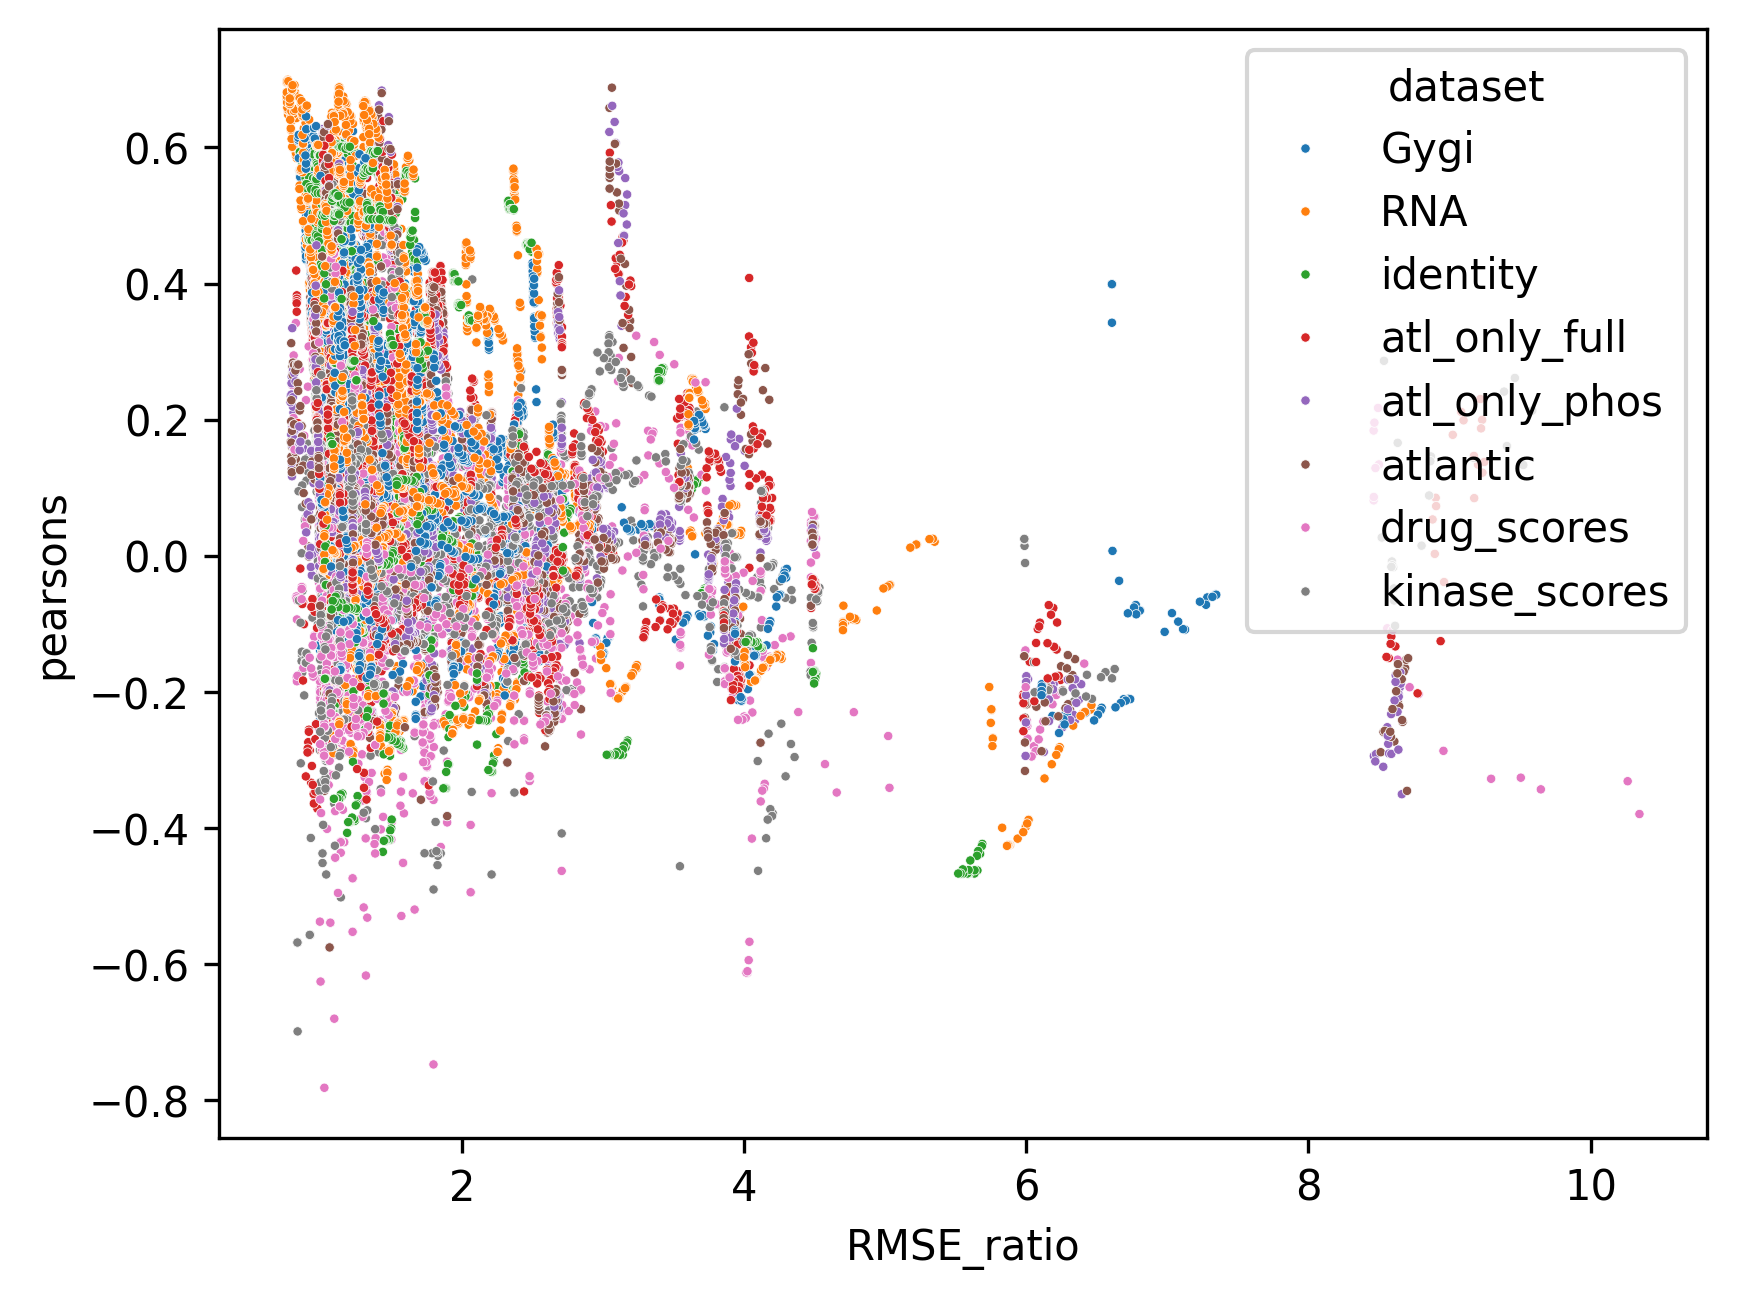

In [85]:
sns.scatterplot(data=df, x='RMSE_ratio', y='pearsons', hue='dataset', s=5)

In [86]:
classes = sorted(set(df['Class']))
datasets = sorted(set(df['dataset']))
alphas = sorted(set(df['alpha']))
l1_ratios = sorted(set(df['l1_ratio']))

In [143]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Find the optimal l1 and alphas for each class and each dataset
frames = []
for c in tqdm(classes):
    for d in datasets:
        Dfs = df[(df['Class']==c)&(df['dataset']==d)].copy()
        als = []
        l1s = []
        mps = []
        for alpha in alphas:
            for l1 in l1_ratios:
                Dfss = Dfs[(Dfs['alpha']==alpha)&(Dfs['l1_ratio']==l1)].copy()
                
                median_pearson = np.nanmedian(Dfss['pearsons'])

                als.append(alpha)
                l1s.append(l1)
                mps.append(median_pearson)
        dfr = pd.DataFrame({'alpha':als, 'l1_ratio':l1s, 'median_pearsons':mps})
        a,b = dfr.sort_values('median_pearsons', ascending=False).iloc[:1][['alpha', 'l1_ratio']].values[0]
        Dfta = df[(df['alpha']==a)&(df['l1_ratio']==b)&(df['Class']==c)&(df['dataset']==d)].copy()
        frames.append(Dfta)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.99it/s]


In [145]:
Dfn = pd.concat(frames, ignore_index=True)

In [146]:
# The result from the grid-search
dfm = pd.read_pickle('/home/icb/manuel.gander/Atl/n2/Grid/dfm.pkl')
dfm = dfm[dfm['source']=='GDSC2'].copy()

In [147]:
# Get intersection
combs0 = [(a,b) for a,b in zip(Dfn['PubChem_CID'], Dfn['dataset'])]
combs1 = [(a,b) for a,b in zip(dfm['PubChem_CID'], dfm['dataset'])]
intersect = set(combs0)&set(combs1)

In [148]:
dfm

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio
13199,10127622,1.00,0.01,Gygi,GDSC2,0.562309,0.493049,0.860996,0.128901,0.154542,49.5,299.0,1.000000e+09,selumetinib,0.834082
13200,10384072,1.00,0.01,Gygi,GDSC2,0.390463,0.290368,0.934548,0.088073,0.095383,49.5,297.0,1.000000e+09,Wee1 Inhibitor,0.923365
13201,11152667,0.01,0.01,Gygi,GDSC2,0.505810,0.389107,0.939969,0.093283,0.107376,49.5,298.0,1.000000e+09,AZD7762,0.868754
13202,11228183,1.00,0.01,Gygi,GDSC2,0.537899,0.310062,0.893763,0.103136,0.120628,49.5,297.0,1.000000e+09,ABT737,0.854993
13203,11364421,0.30,0.01,Gygi,GDSC2,0.518310,0.508338,0.836971,0.164887,0.191714,49.5,278.0,1.000000e+09,BI-2536,0.860065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13717,9826528,1.00,0.03,kinase_scores,GDSC2,0.538588,0.516173,0.847639,0.121569,0.136048,49.5,82.0,1.000000e+09,PD0325901,0.893572
13718,9887053,0.03,0.90,kinase_scores,GDSC2,0.216081,0.230616,0.981581,0.099387,0.100649,49.5,82.0,1.000000e+09,oxaliplatin,0.987468
13719,9914412,3.00,0.01,kinase_scores,GDSC2,0.266411,0.133321,1.003065,0.101089,0.102171,49.5,80.0,1.000000e+09,ZM447439,0.989415
13720,9936746,0.10,0.30,kinase_scores,GDSC2,0.294705,0.246059,0.984262,0.106270,0.109014,49.5,79.0,1.000000e+09,OTX015,0.974825


In [150]:
len(intersect)

368

In [151]:
f0 = []
for a,b in intersect:
    f0.append(Dfn[(Dfn['PubChem_CID']==a)&(Dfn['dataset']==b)])
Df0 = pd.concat(f0, ignore_index=True)
Df0['set'] = 'comb'


f1 = []
for a,b in intersect:
    f1.append(dfm[(dfm['PubChem_CID']==a)&(dfm['dataset']==b)])
Df1 = pd.concat(f1, ignore_index=True)[['PubChem_CID', 'pearsons', 'RMSE', 'RMSE_mean_model', 'RMSE_ratio', 'dataset']]
D_dr_to_class = dict(zip(Df0['PubChem_CID'], Df0['Class']))
Df1['Class'] = Df1['PubChem_CID'].map(D_dr_to_class)
Df1['set'] = 'grid'

Dfc = pd.concat([Df0, Df1])
Dfc['Method'] = ['Drugs Combined' if a=='comb' else 'Drugs Isolated' for a in Dfc['set']]

In [154]:
D_fn = {'Gygi':'Gygi-CCLE', 'RNA':'Transcriptomics', 'atl_full_and_kinases':'Atl. Full+Kinase scores',
        'atl_only_full':'Atl. Full Proteome', 'atl_only_phos':'Atl. Phosphoproteome',
        'atlantic': 'Atl. Full+Phosphoproteome', 'drug_scores':'Atl. Drug Scores',
        'identity':'Tissue of Origin', 'kinase_scores':'Atl. Kinase Scores'}

In [156]:
Dfc['dataset'] = [D_fn[a] for a in Dfc['dataset']]

In [162]:
from pandas.api.types import CategoricalDtype

Dfc['Method'] = Dfc['Method'].astype(CategoricalDtype(categories=['Drugs Isolated', 'Drugs Combined'], ordered=True))

Atl. Drug Scores


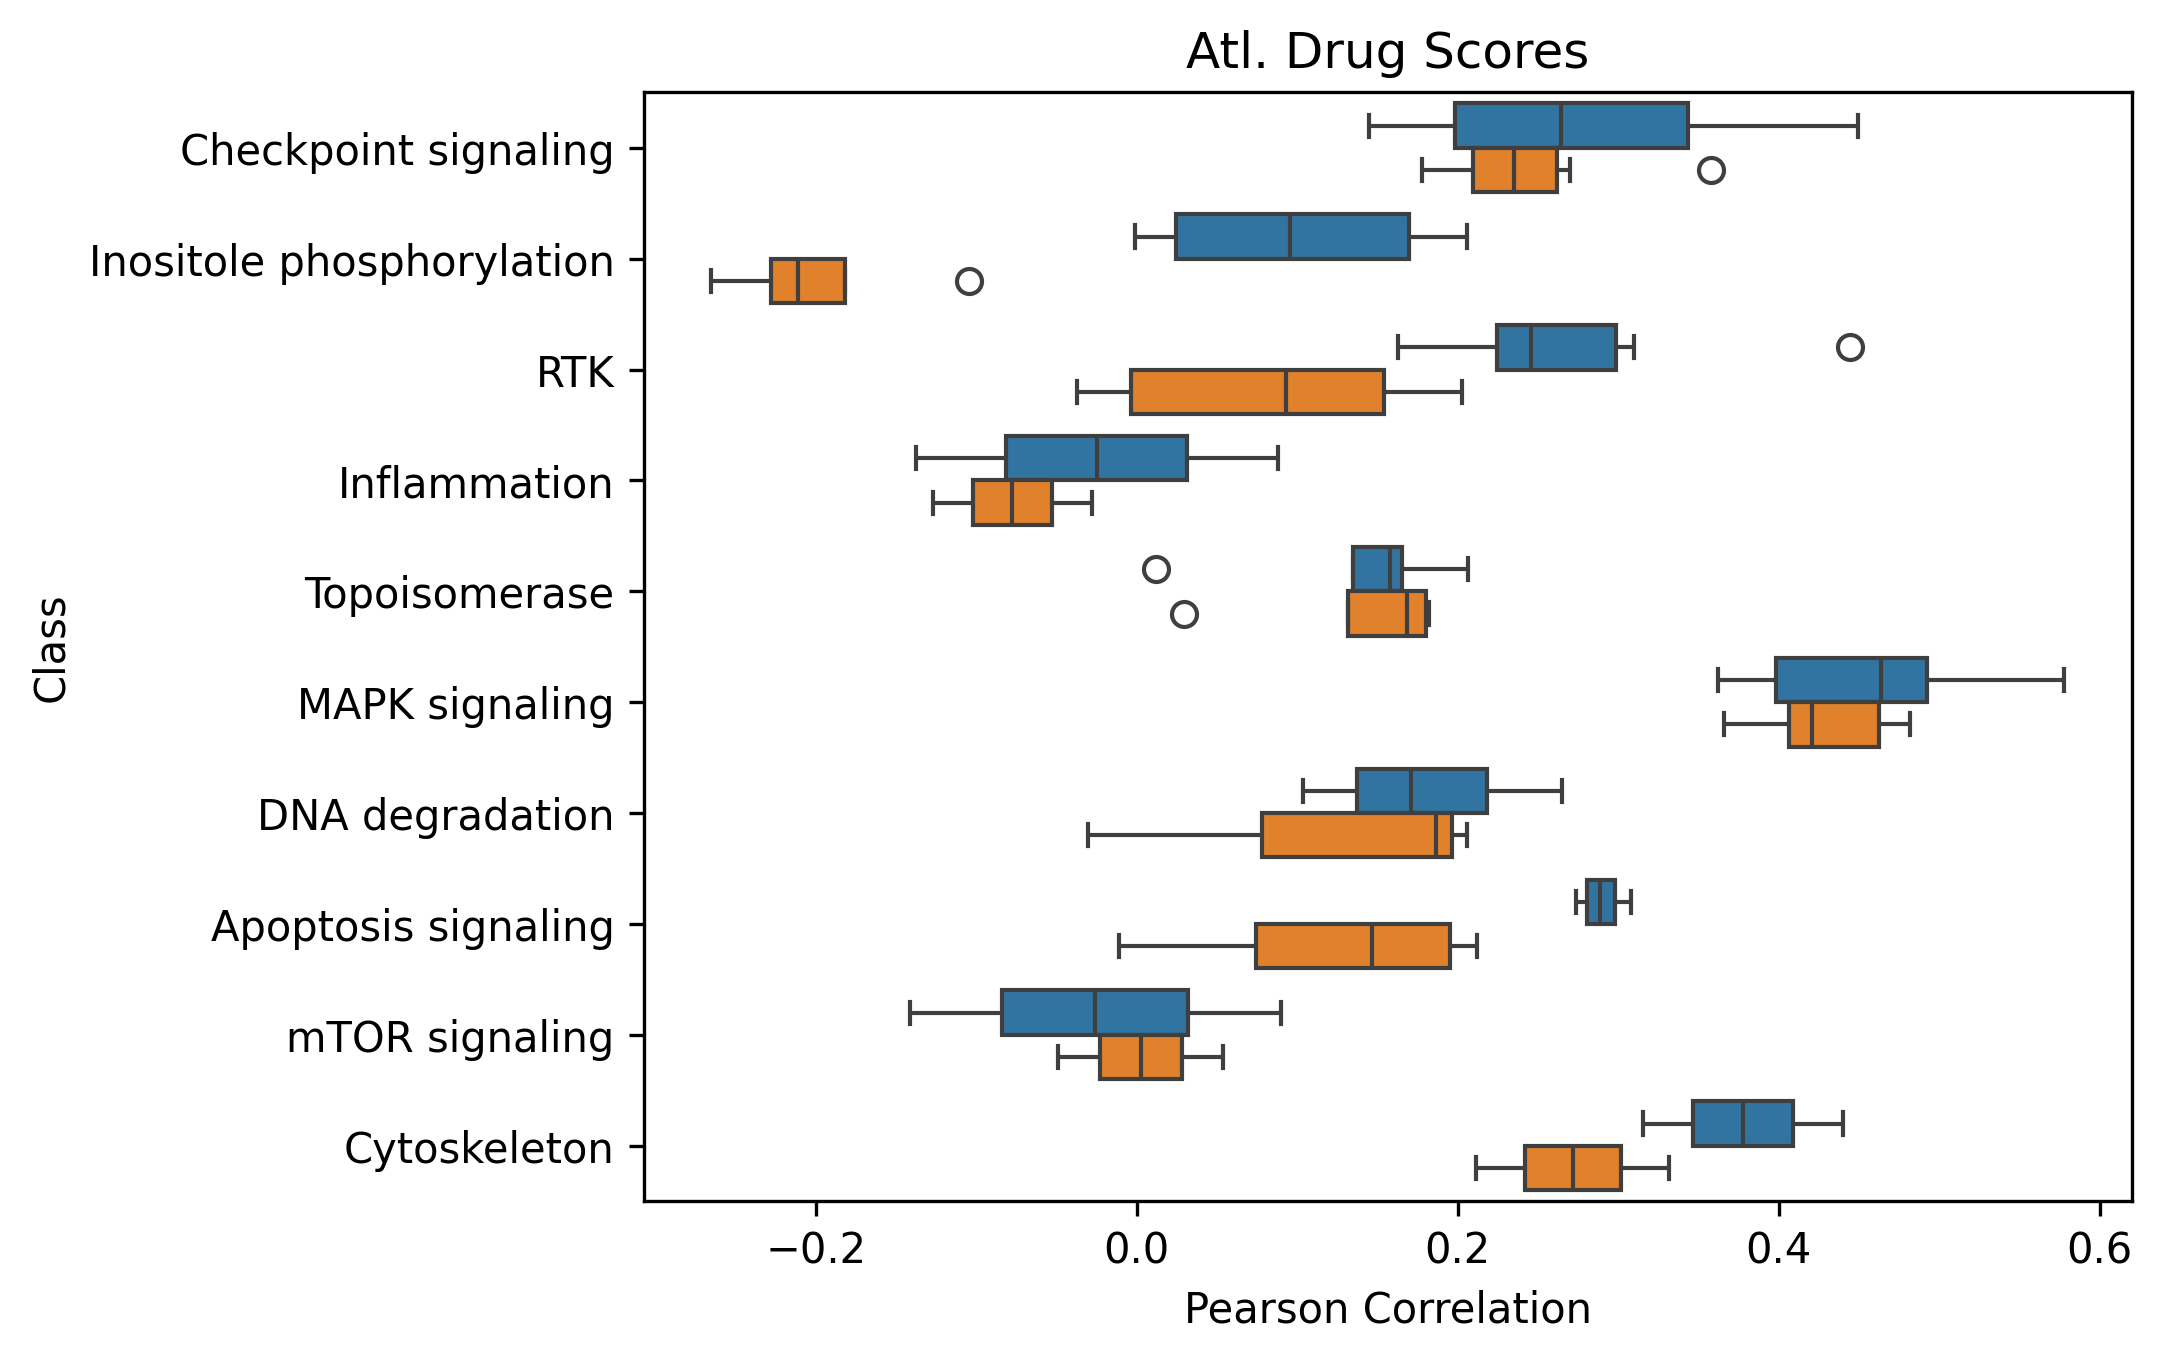

Atl. Full Proteome


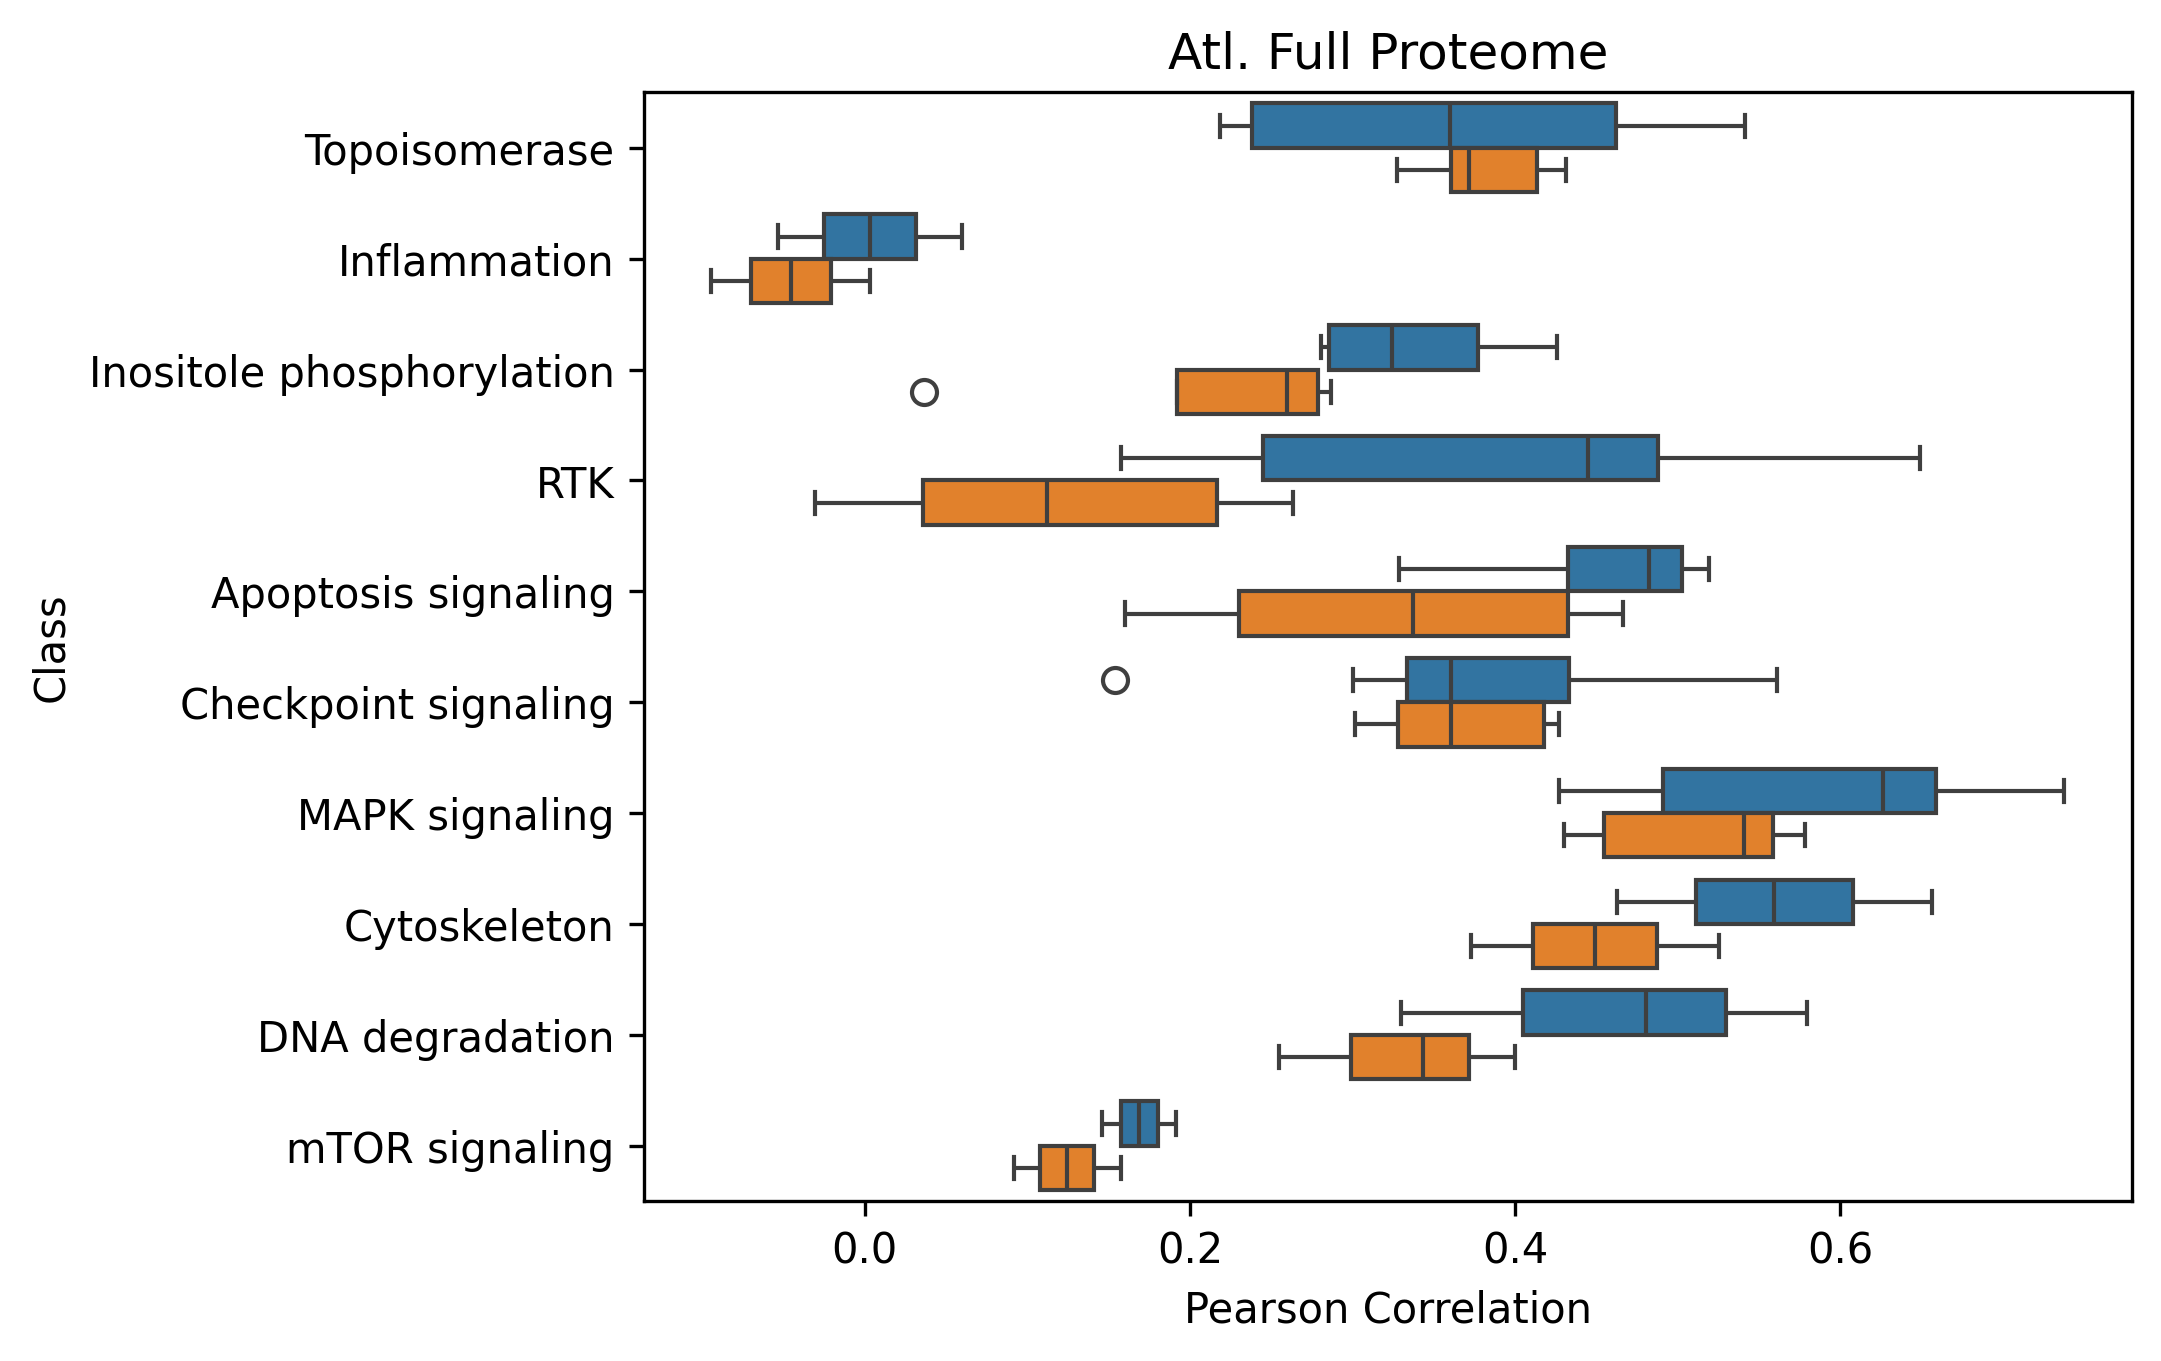

Atl. Full+Phosphoproteome


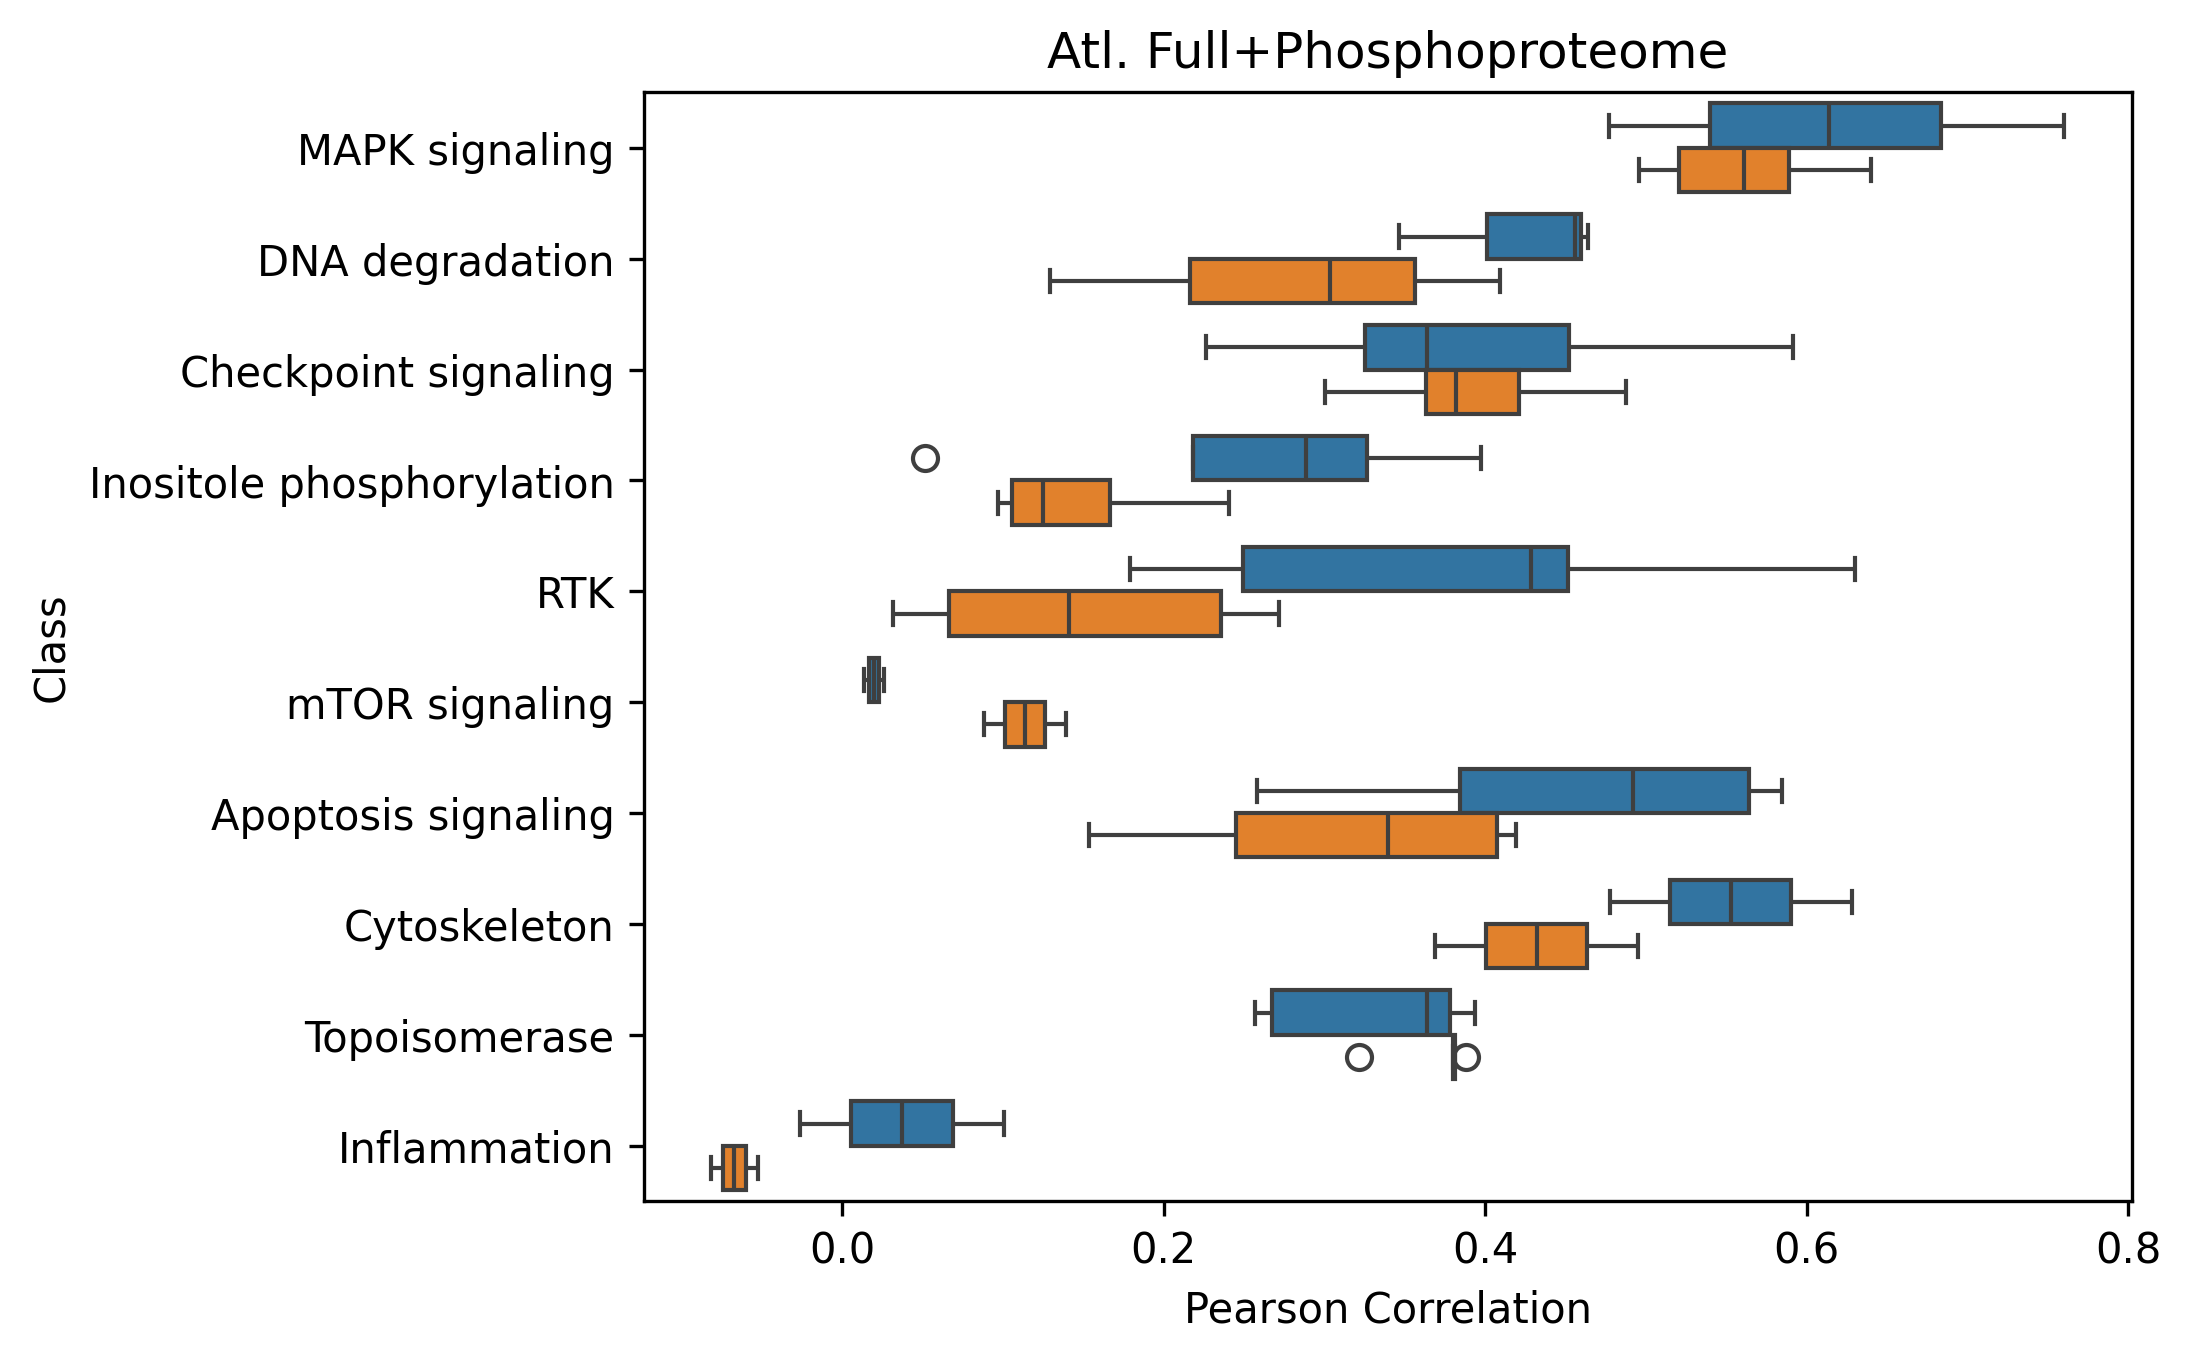

Atl. Kinase Scores


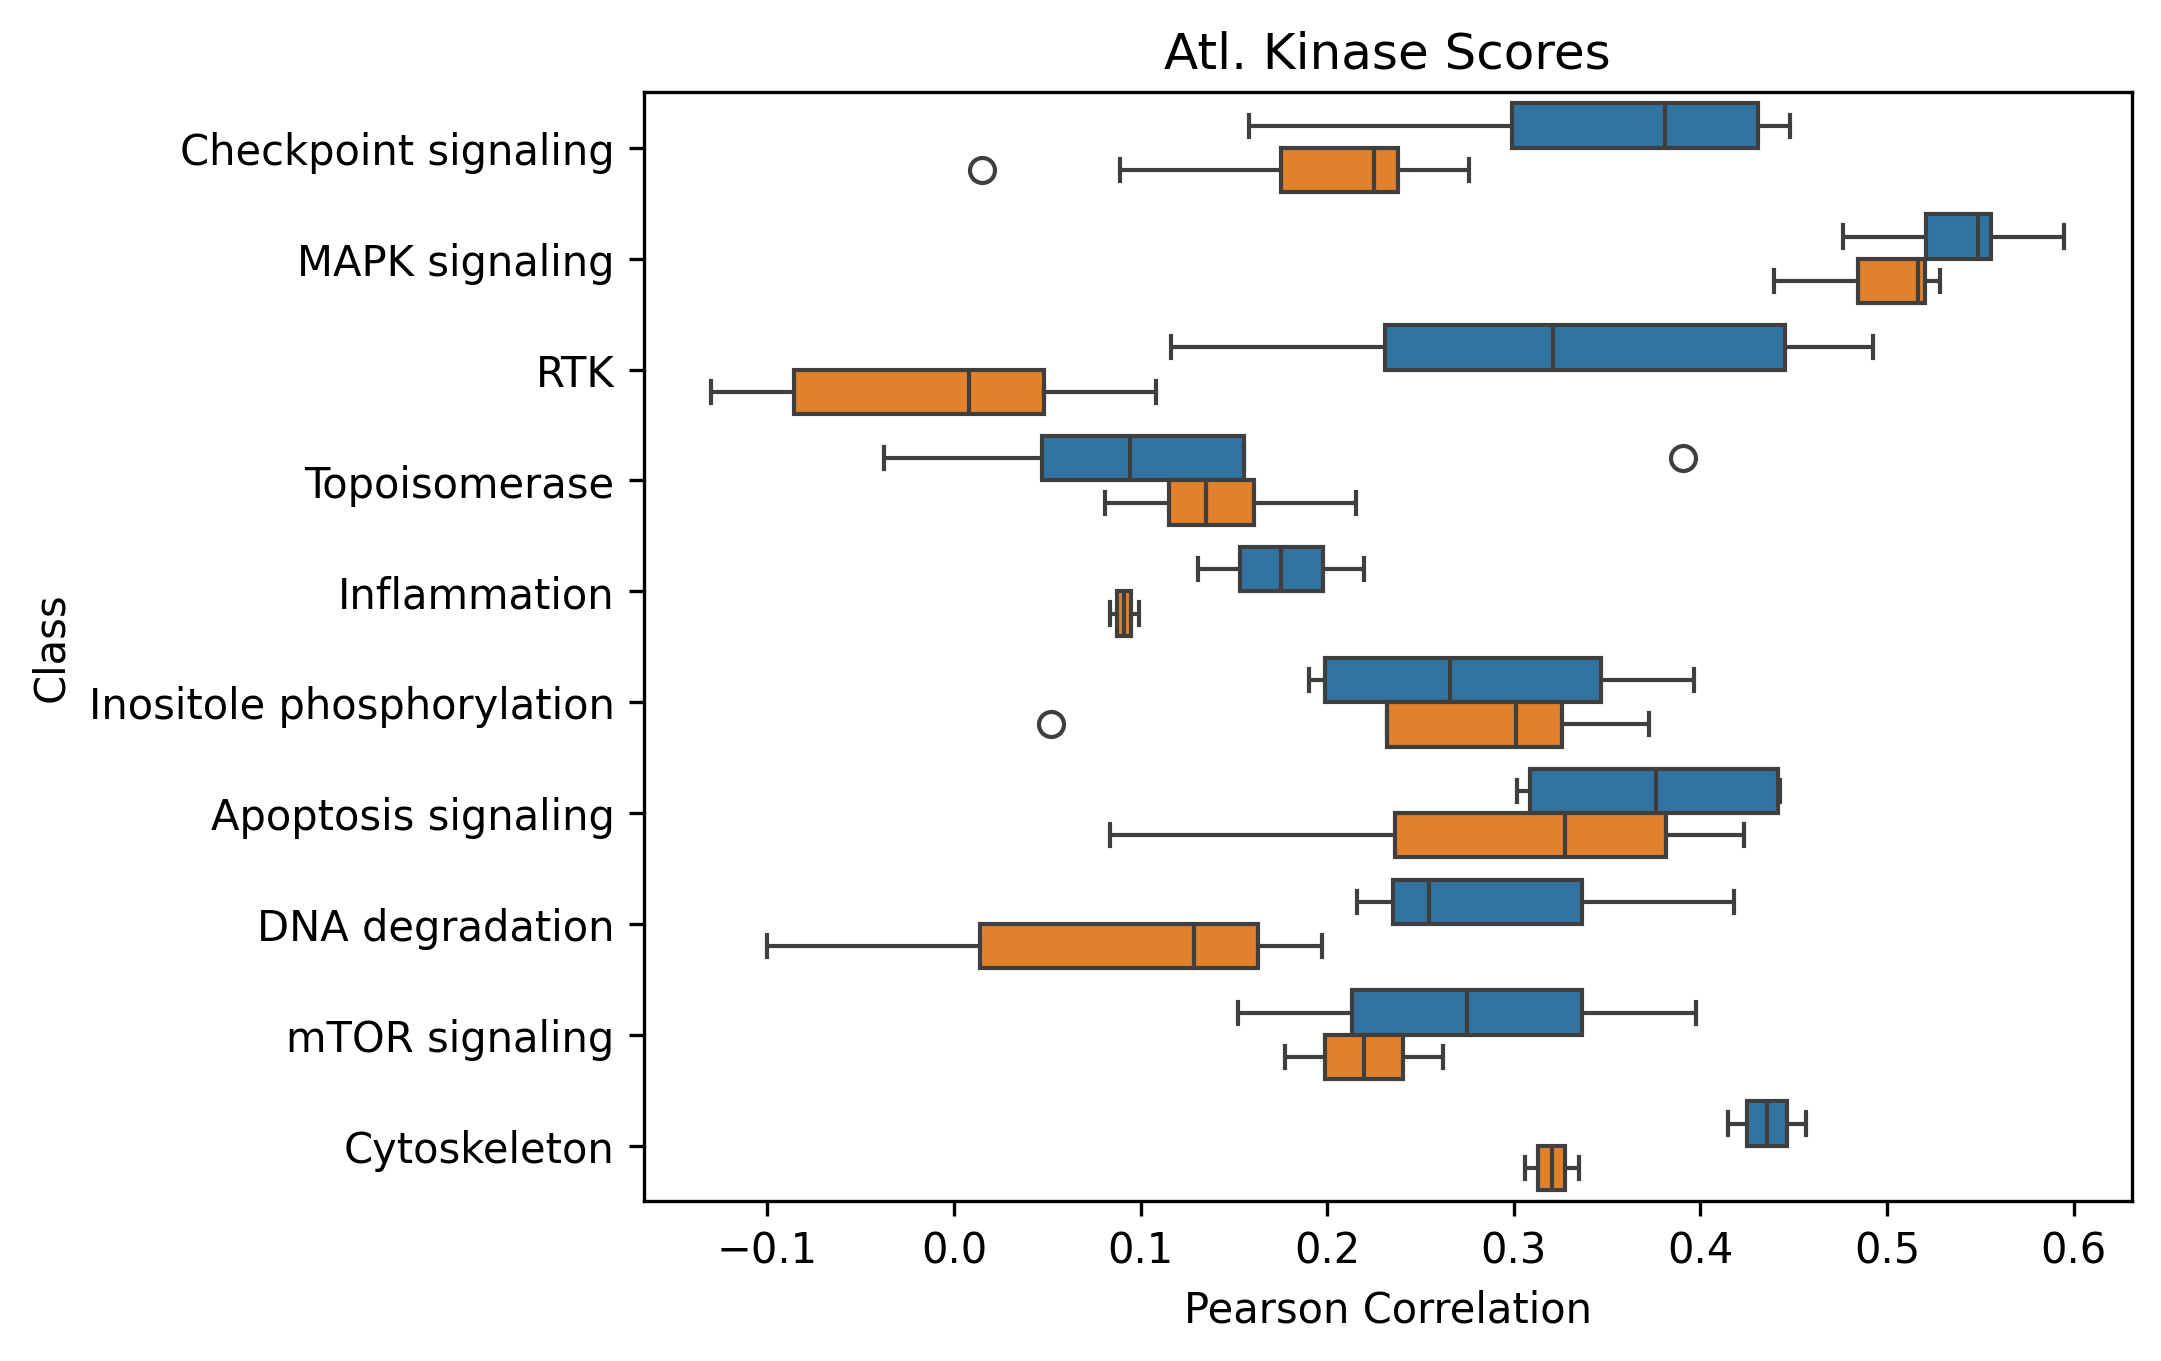

Atl. Phosphoproteome


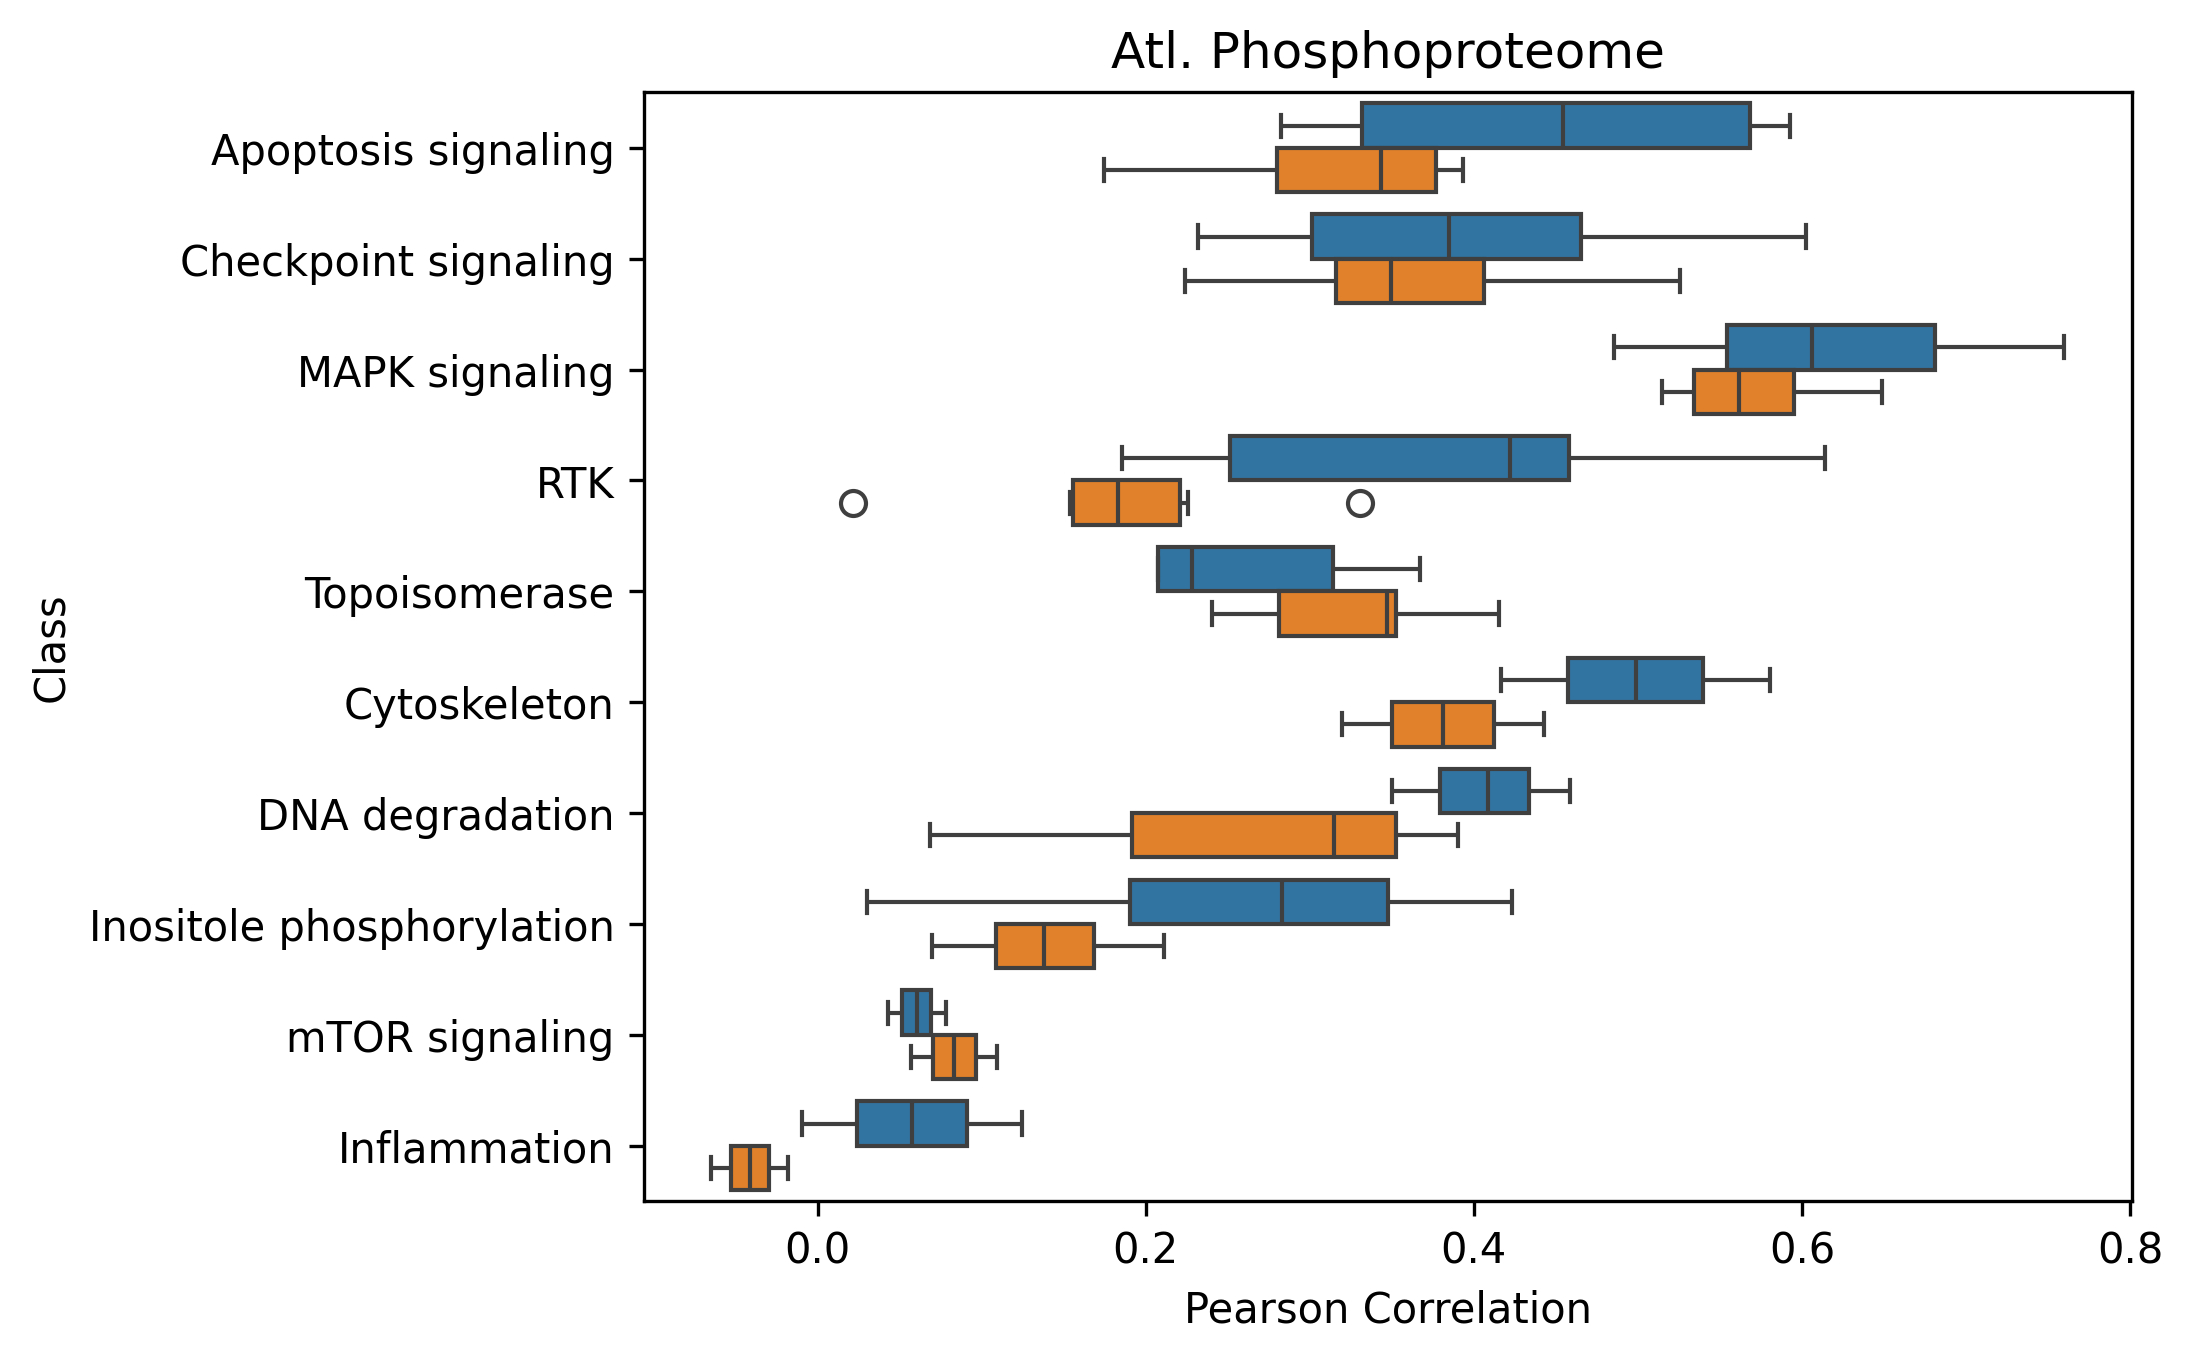

Gygi-CCLE


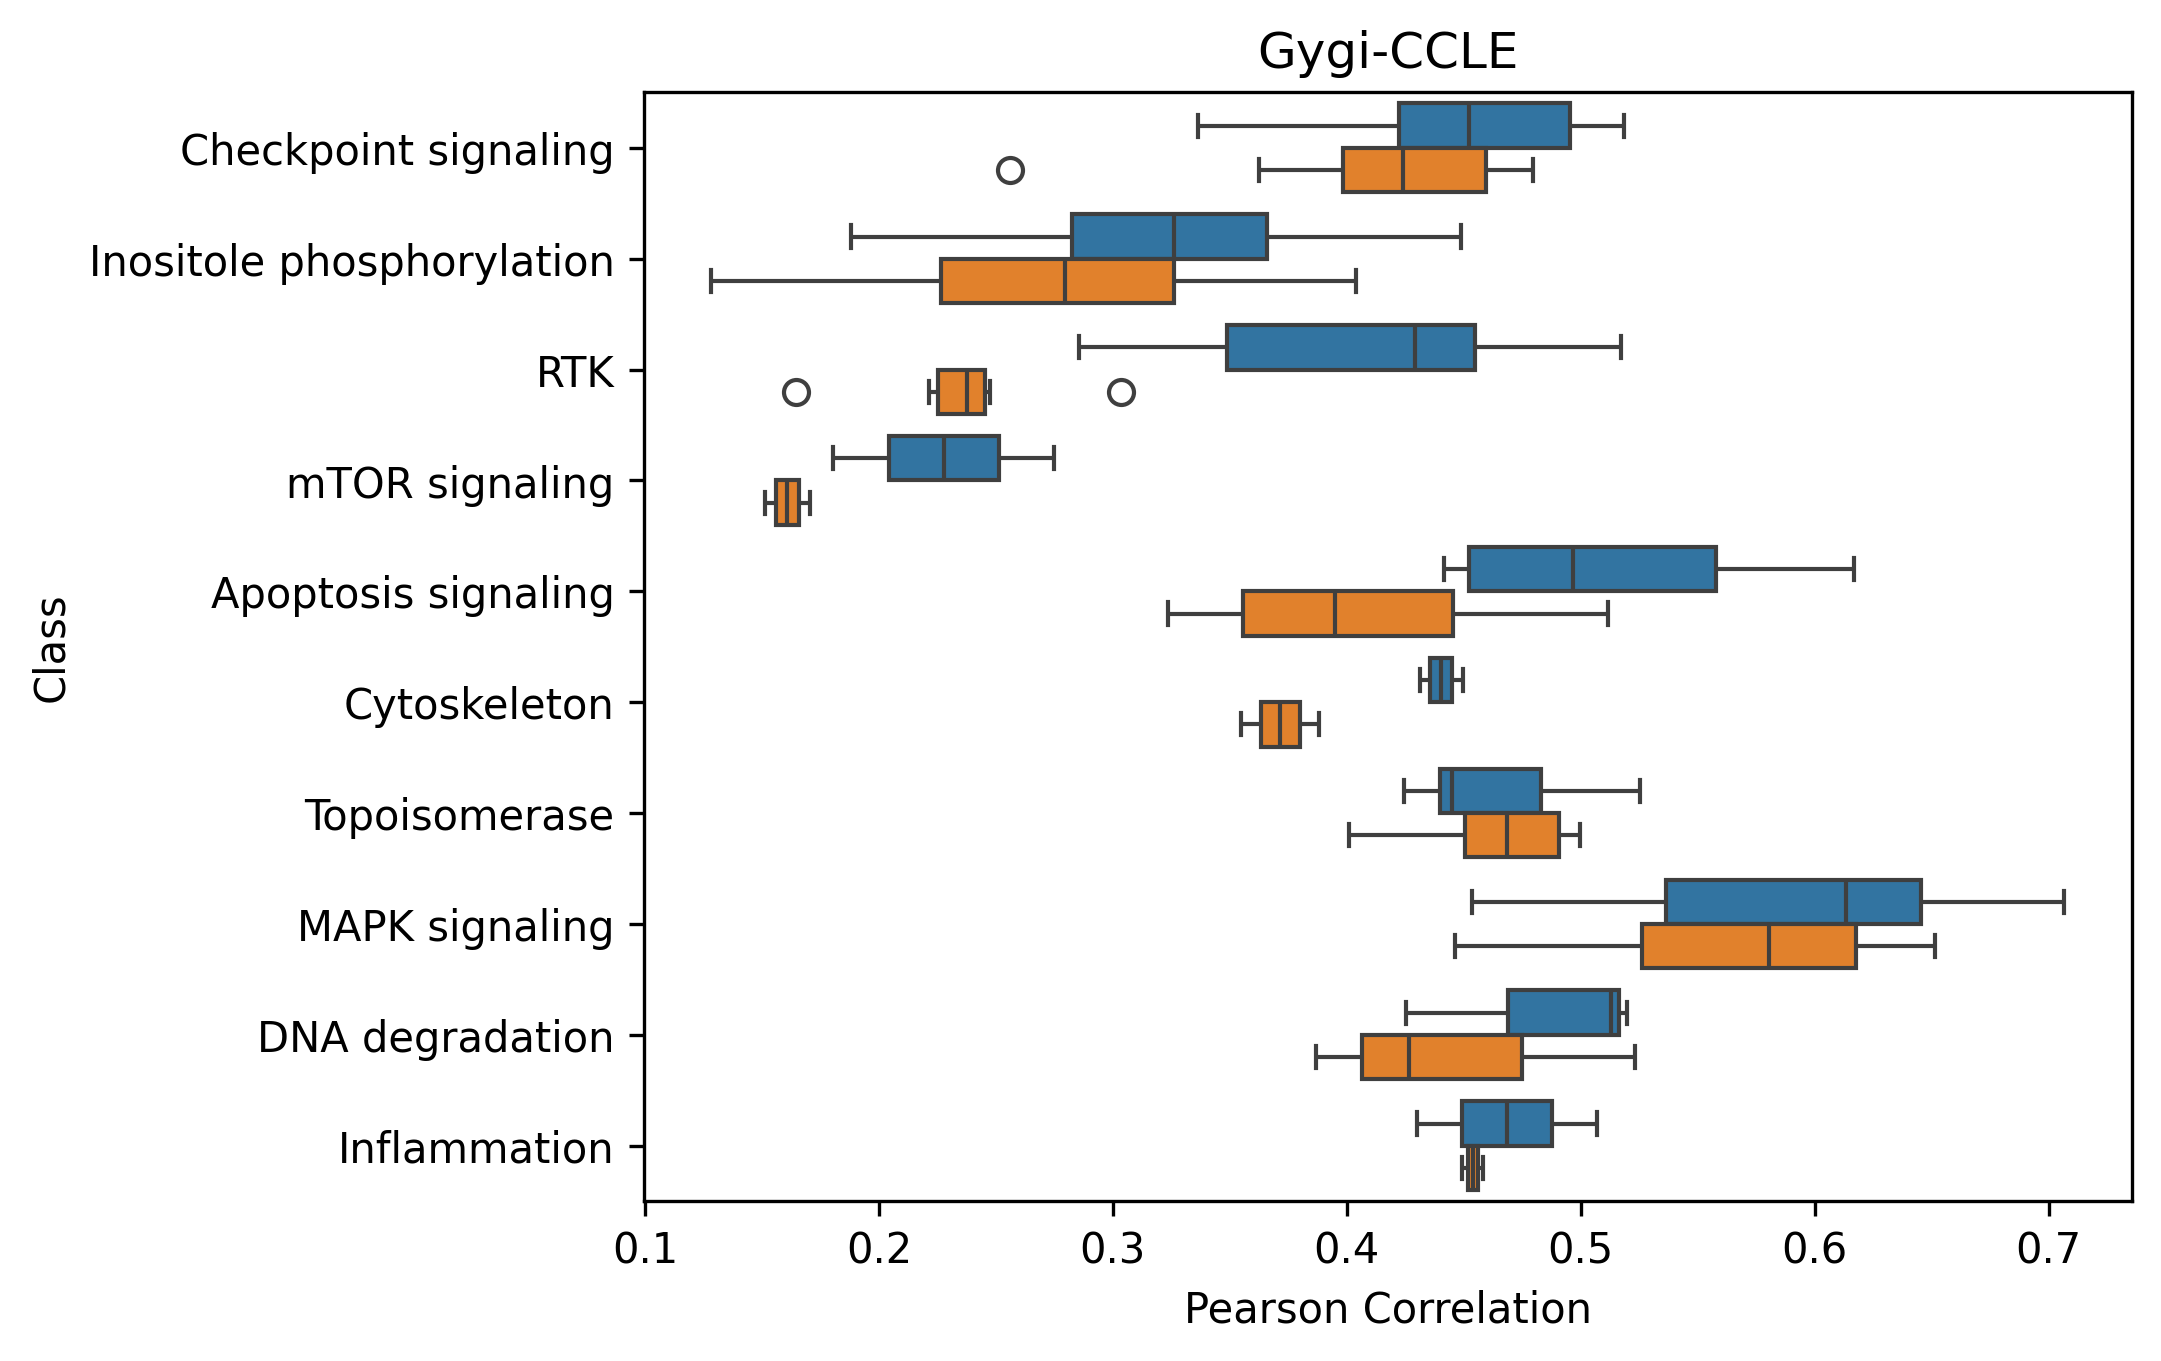

Tissue of Origin


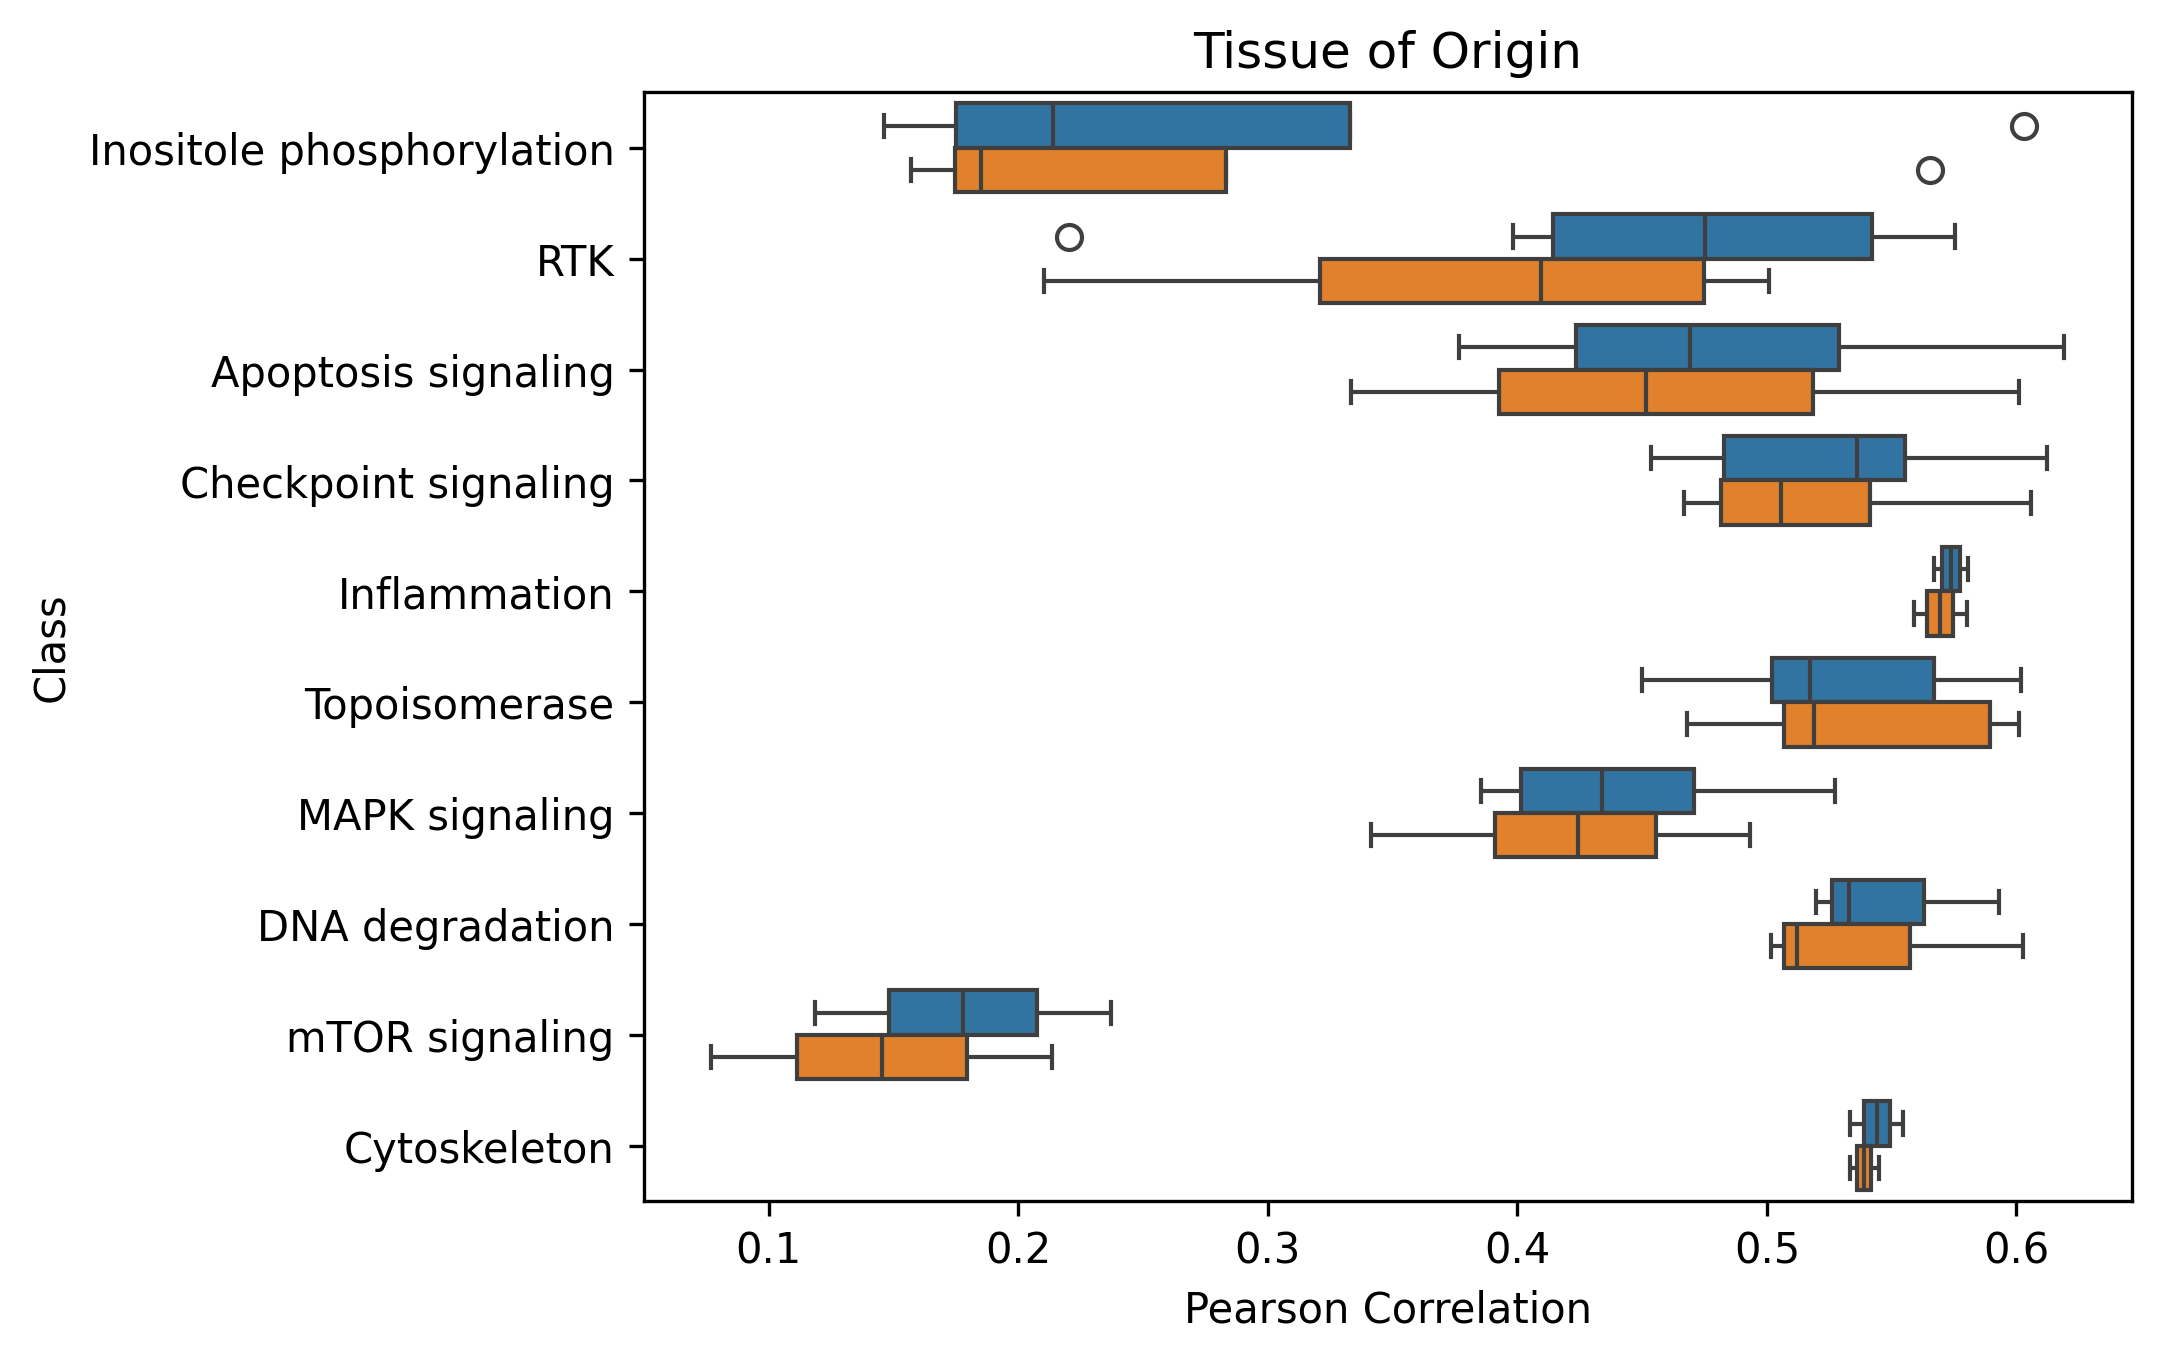

Transcriptomics


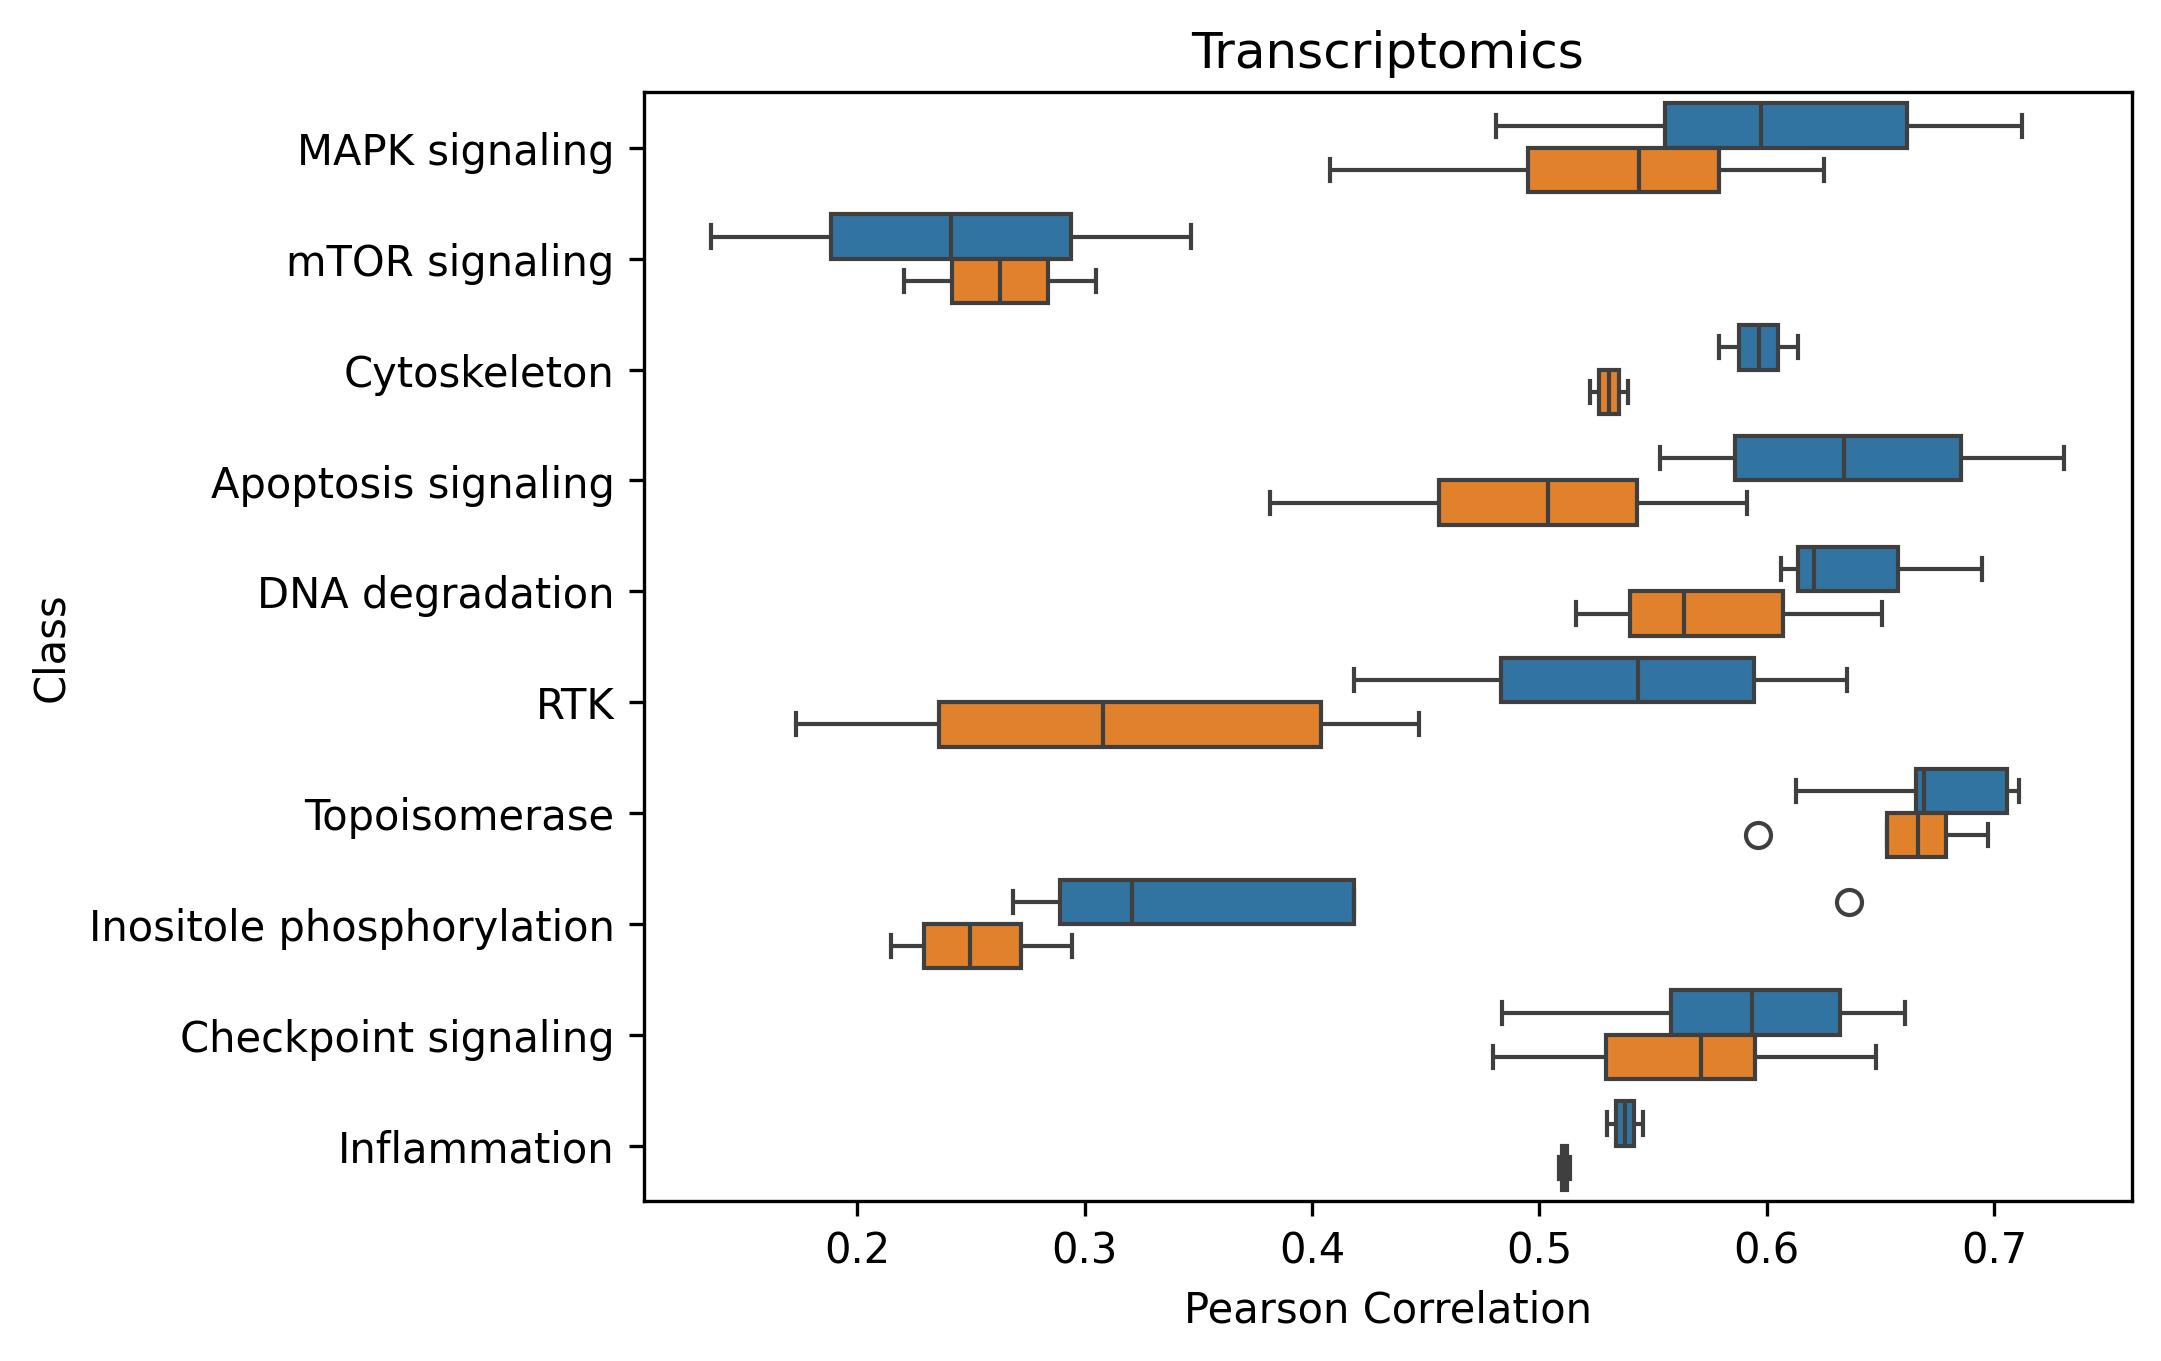

In [164]:
datasets = sorted(set(Dfc['dataset']))
for dataset in datasets:
    print(dataset)
    Dfcs = Dfc[Dfc['dataset']==dataset].copy()
    vc = Dfcs['Class'].value_counts()
    Dfcss = Dfcs[Dfcs['Class'].isin(vc[vc>2].index)].copy()
    Dfcss['Class'] = list(Dfcss['Class'])
    sns.boxplot(data=Dfcss, x='pearsons', y='Class', hue='Method', legend=None)
    plt.title(dataset)
    plt.xlabel('Pearson Correlation')
    plt.pause(0.01)

Atl. Drug Scores


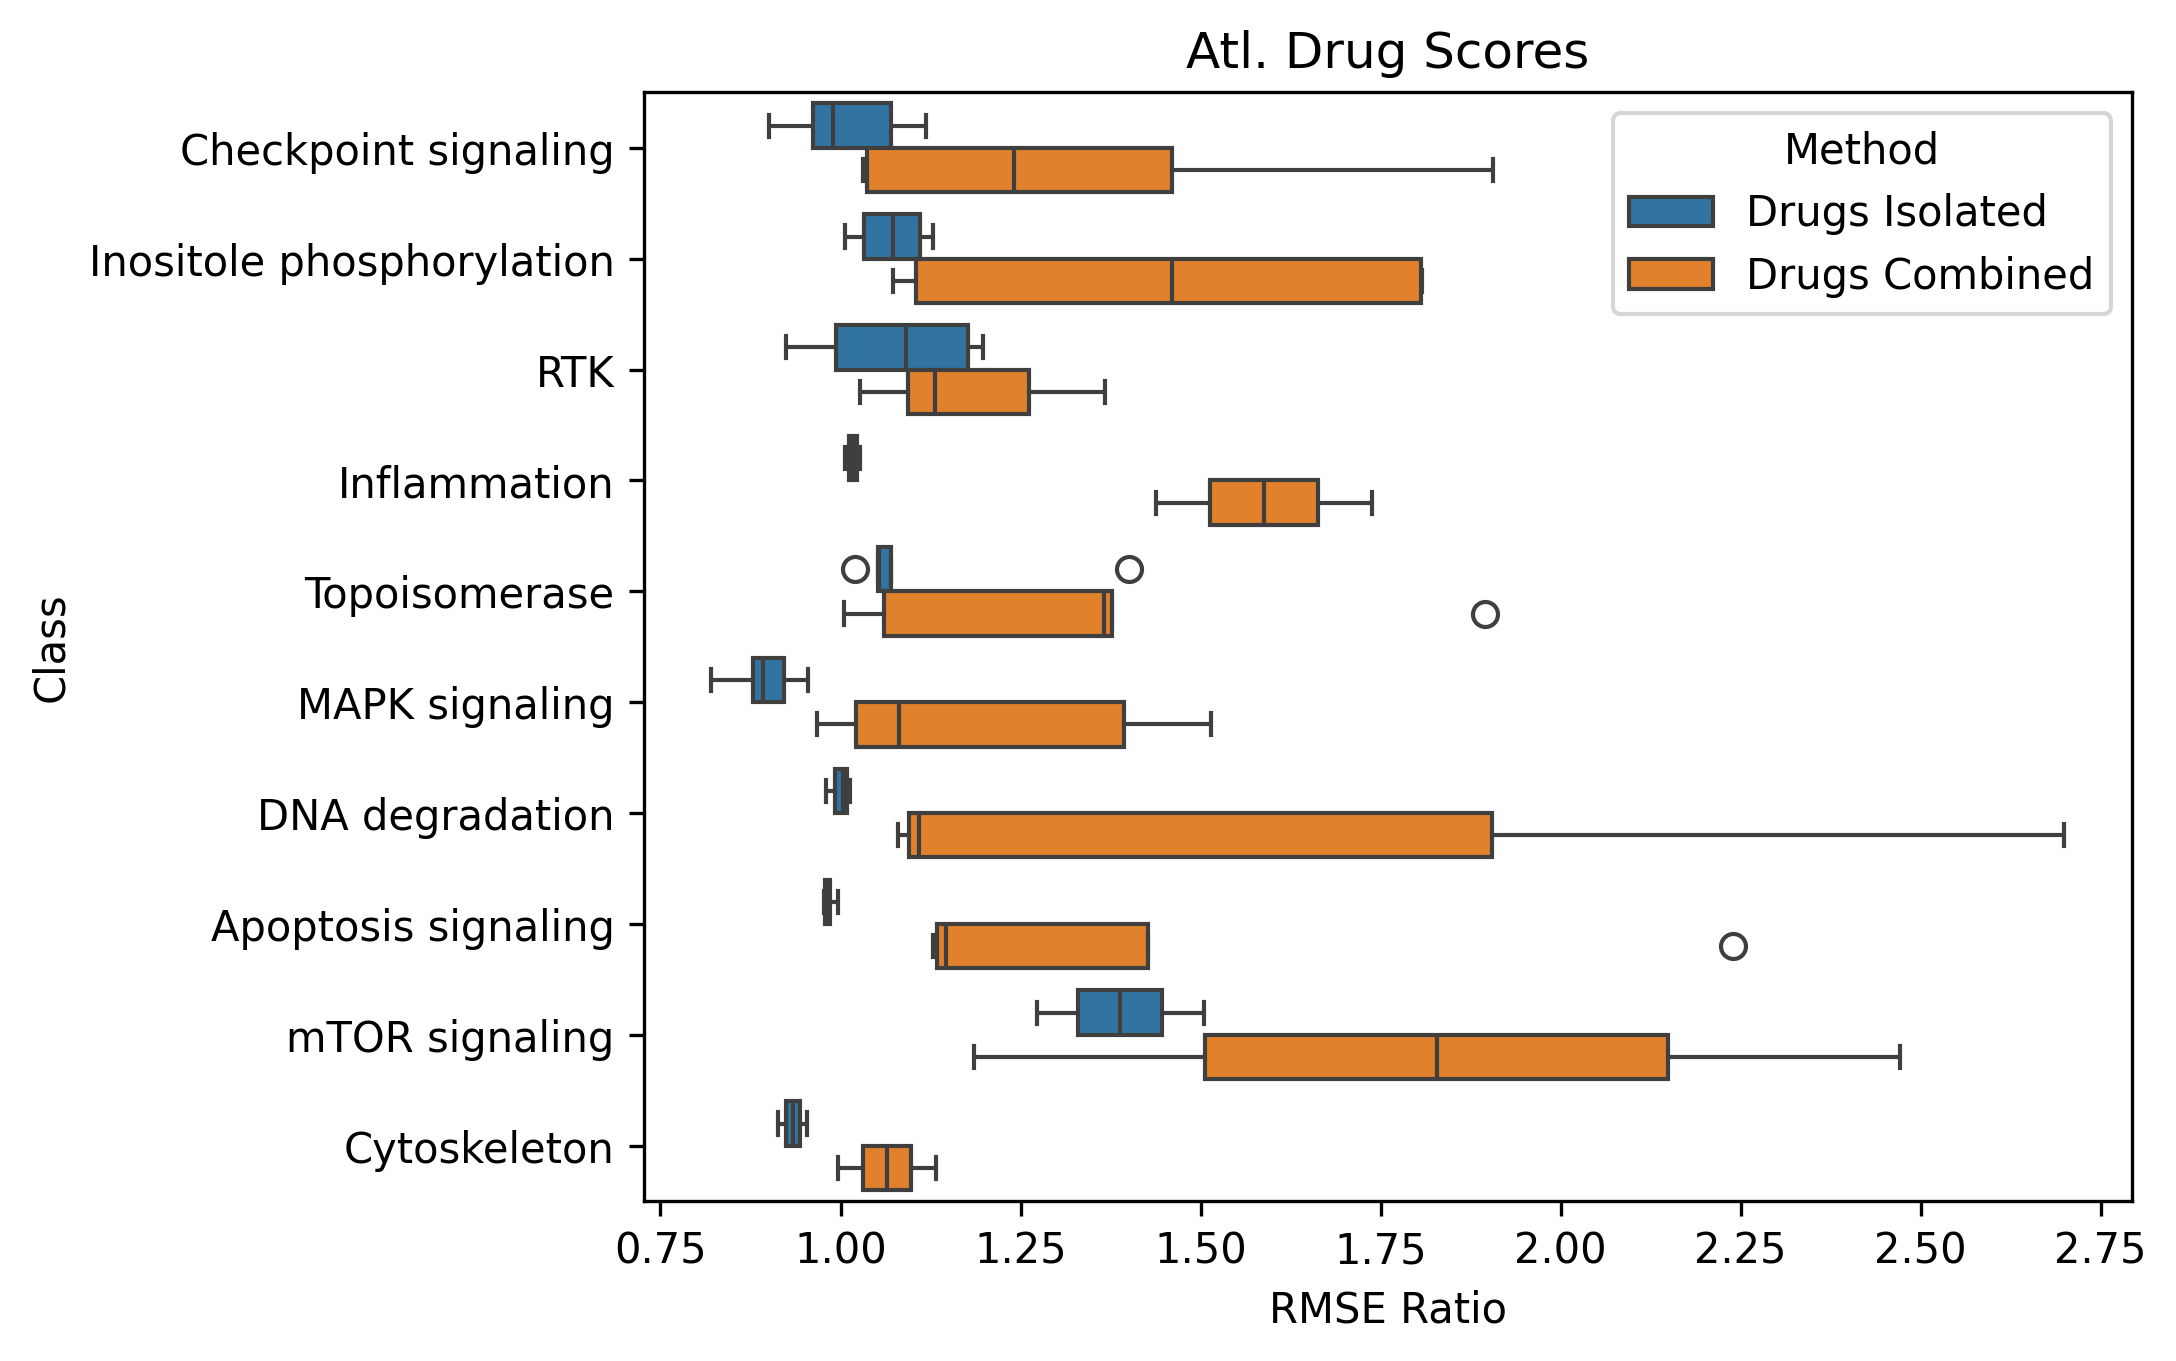

Atl. Full Proteome


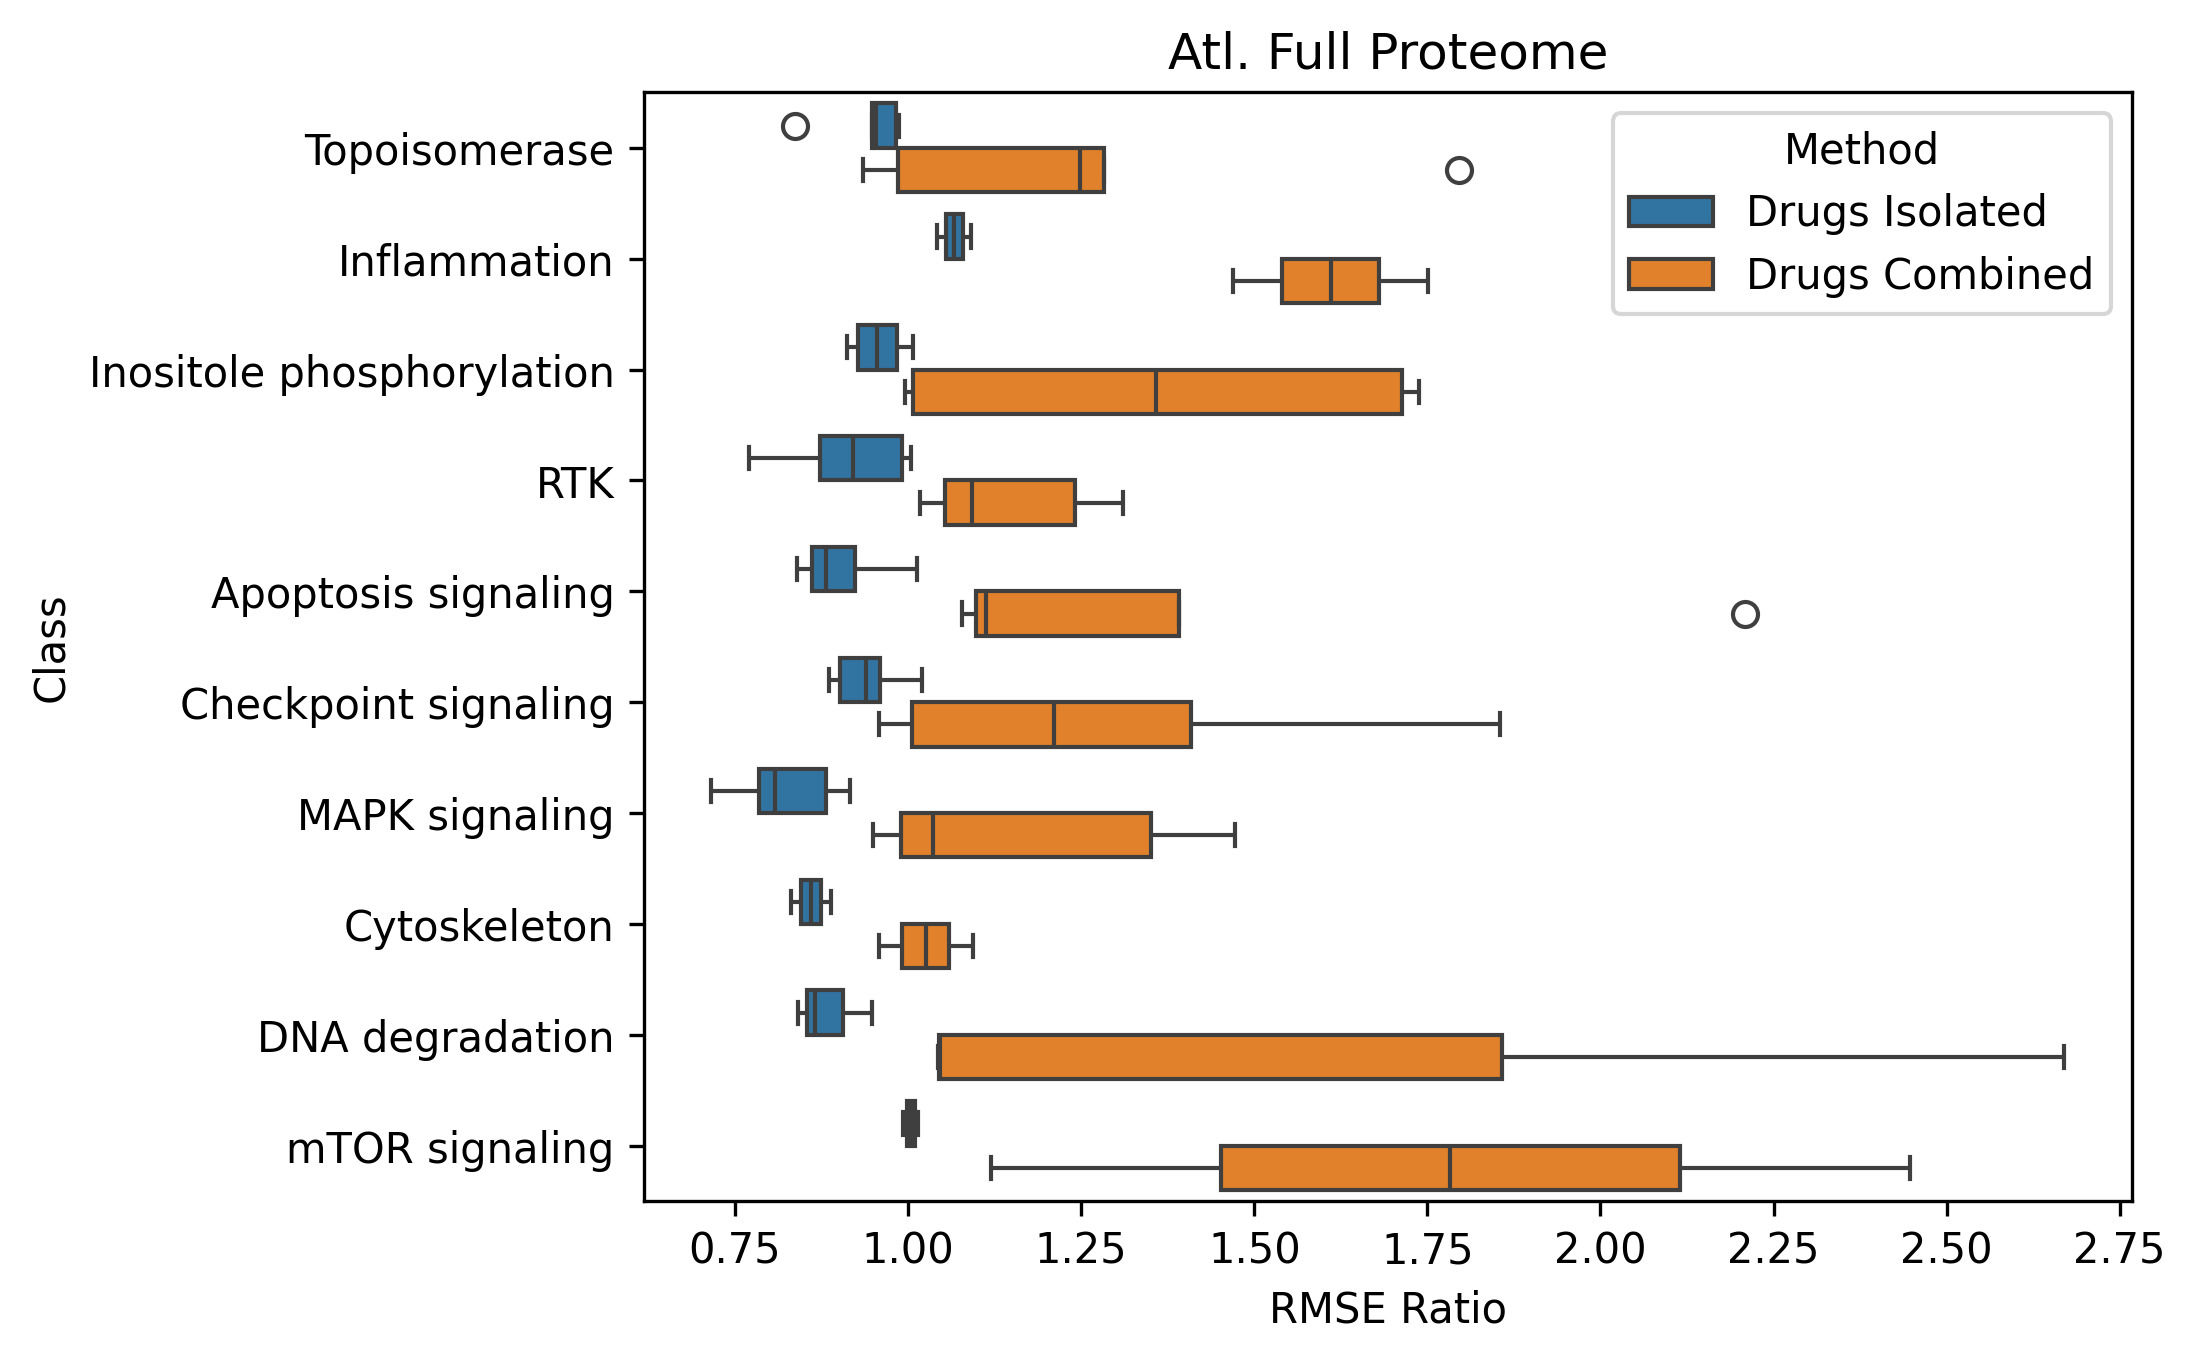

Atl. Full+Phosphoproteome


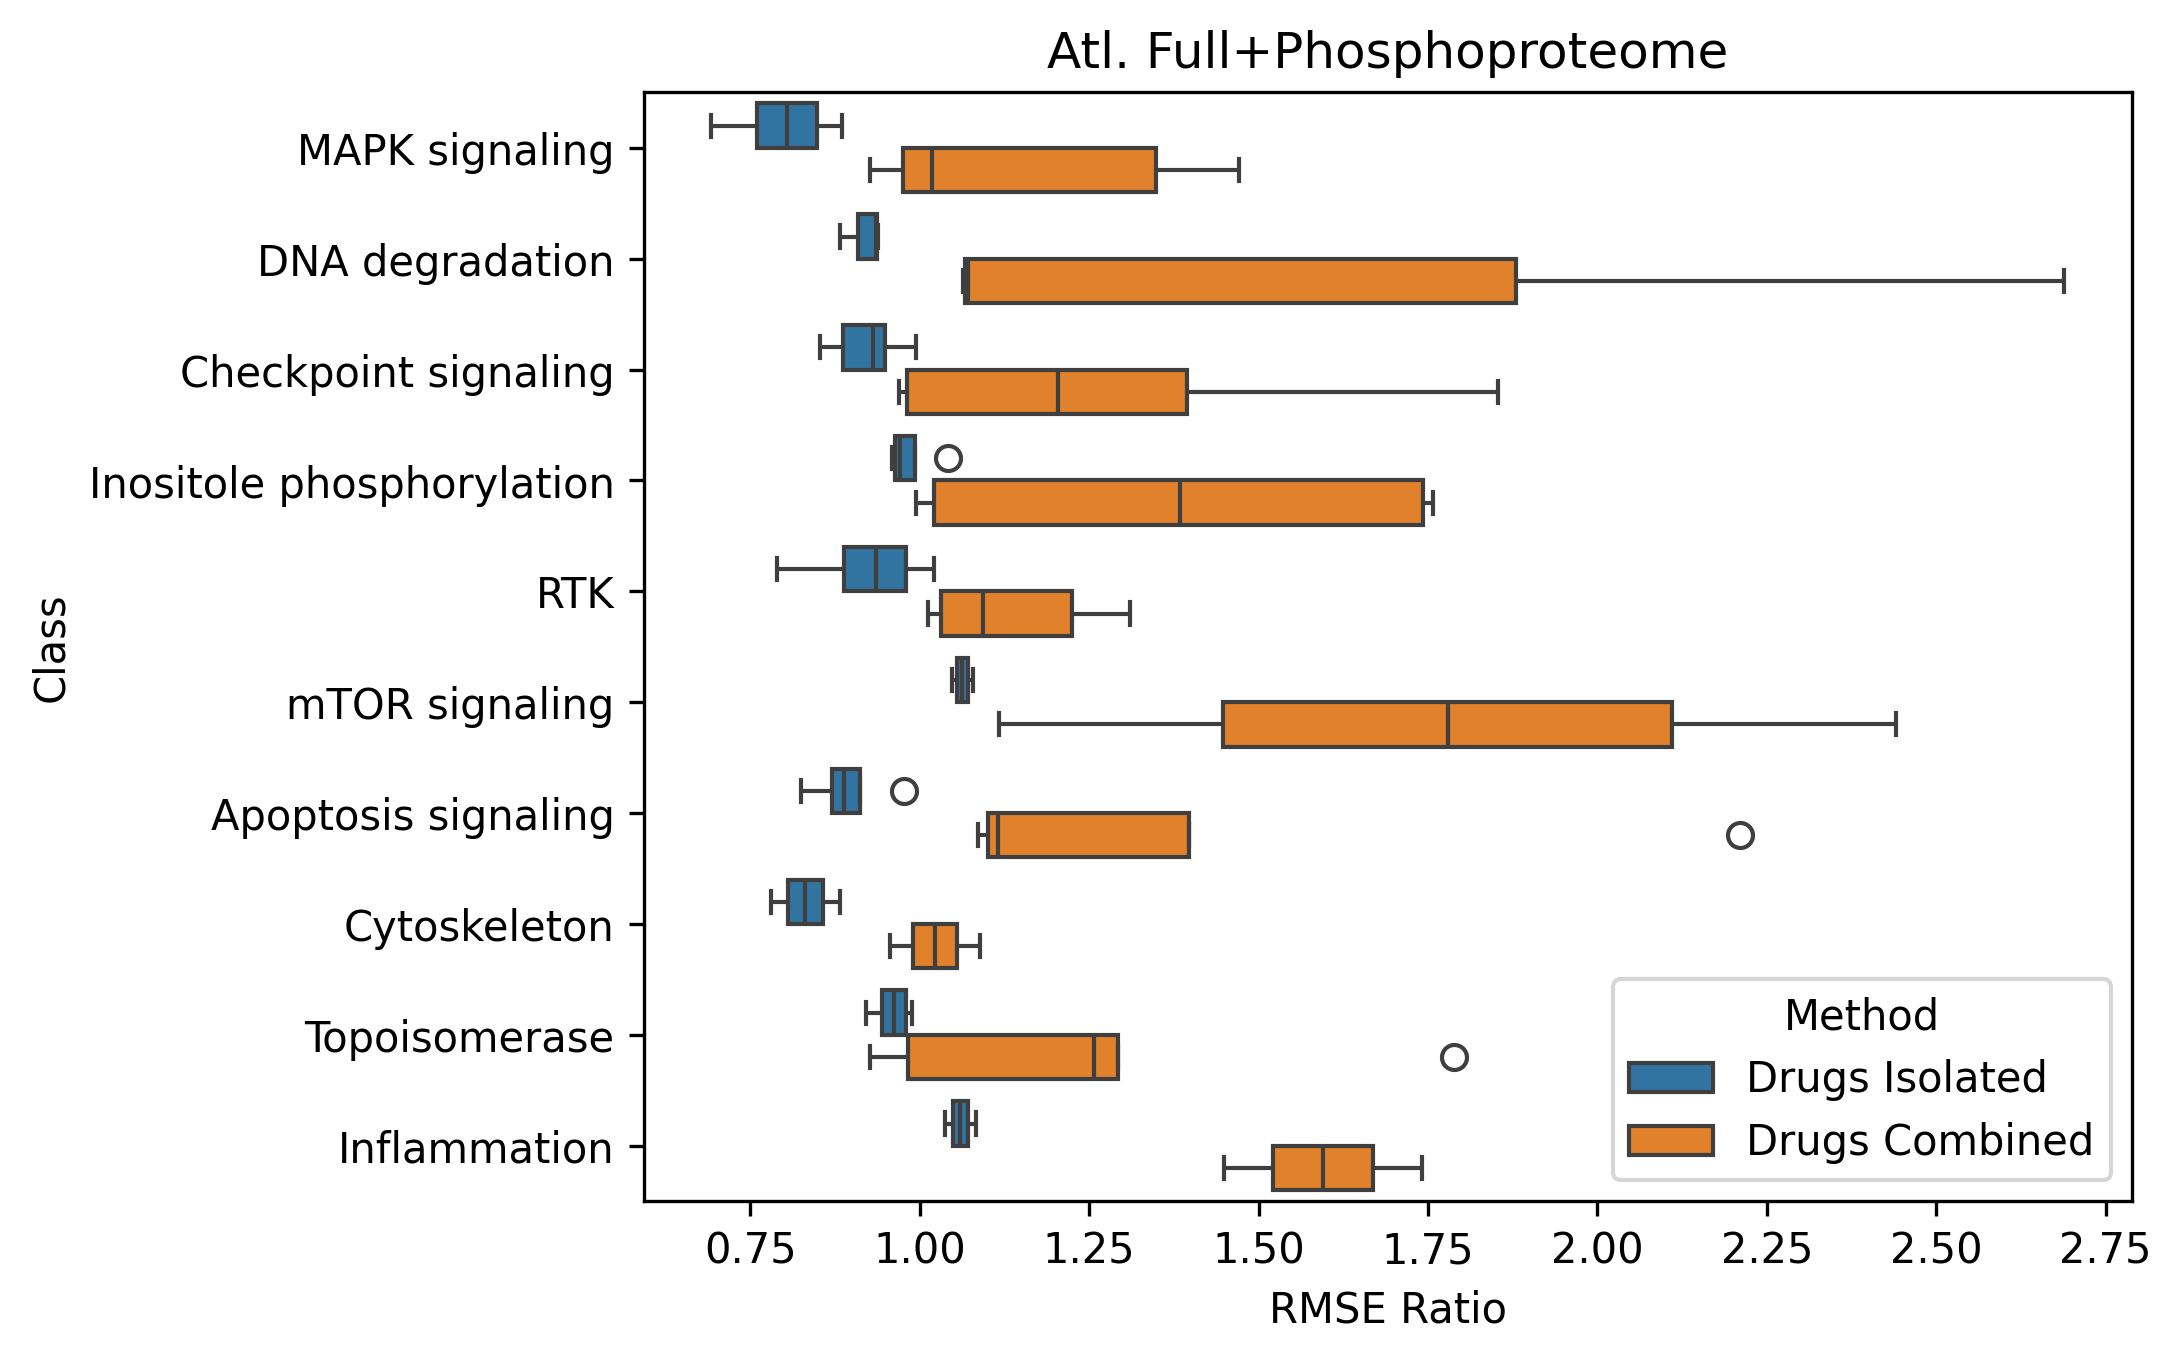

Atl. Kinase Scores


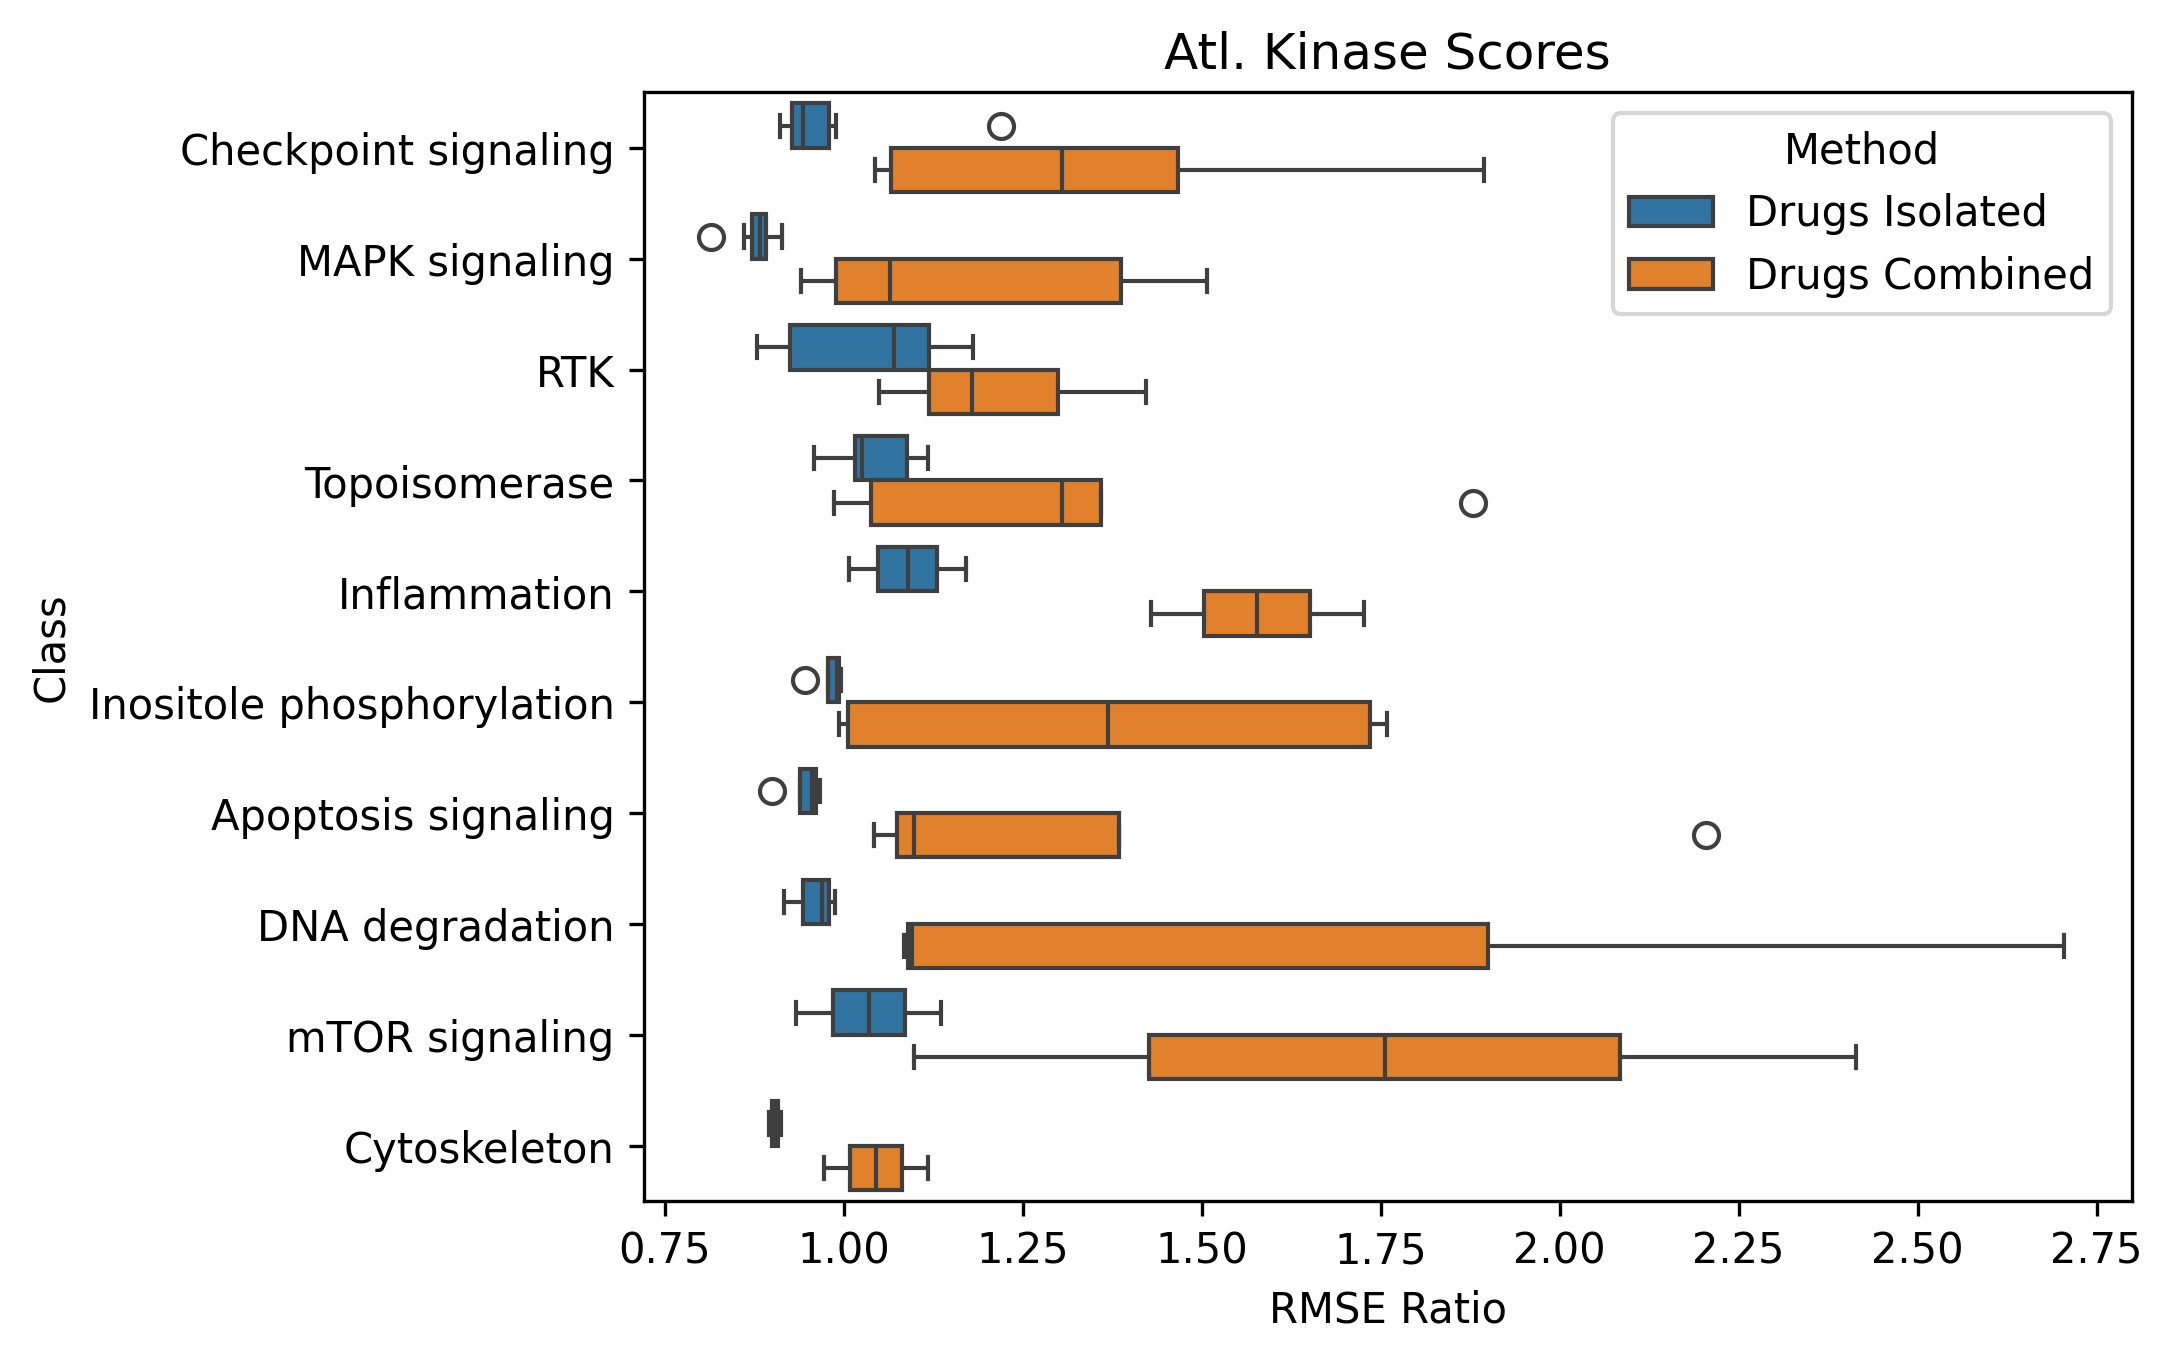

Atl. Phosphoproteome


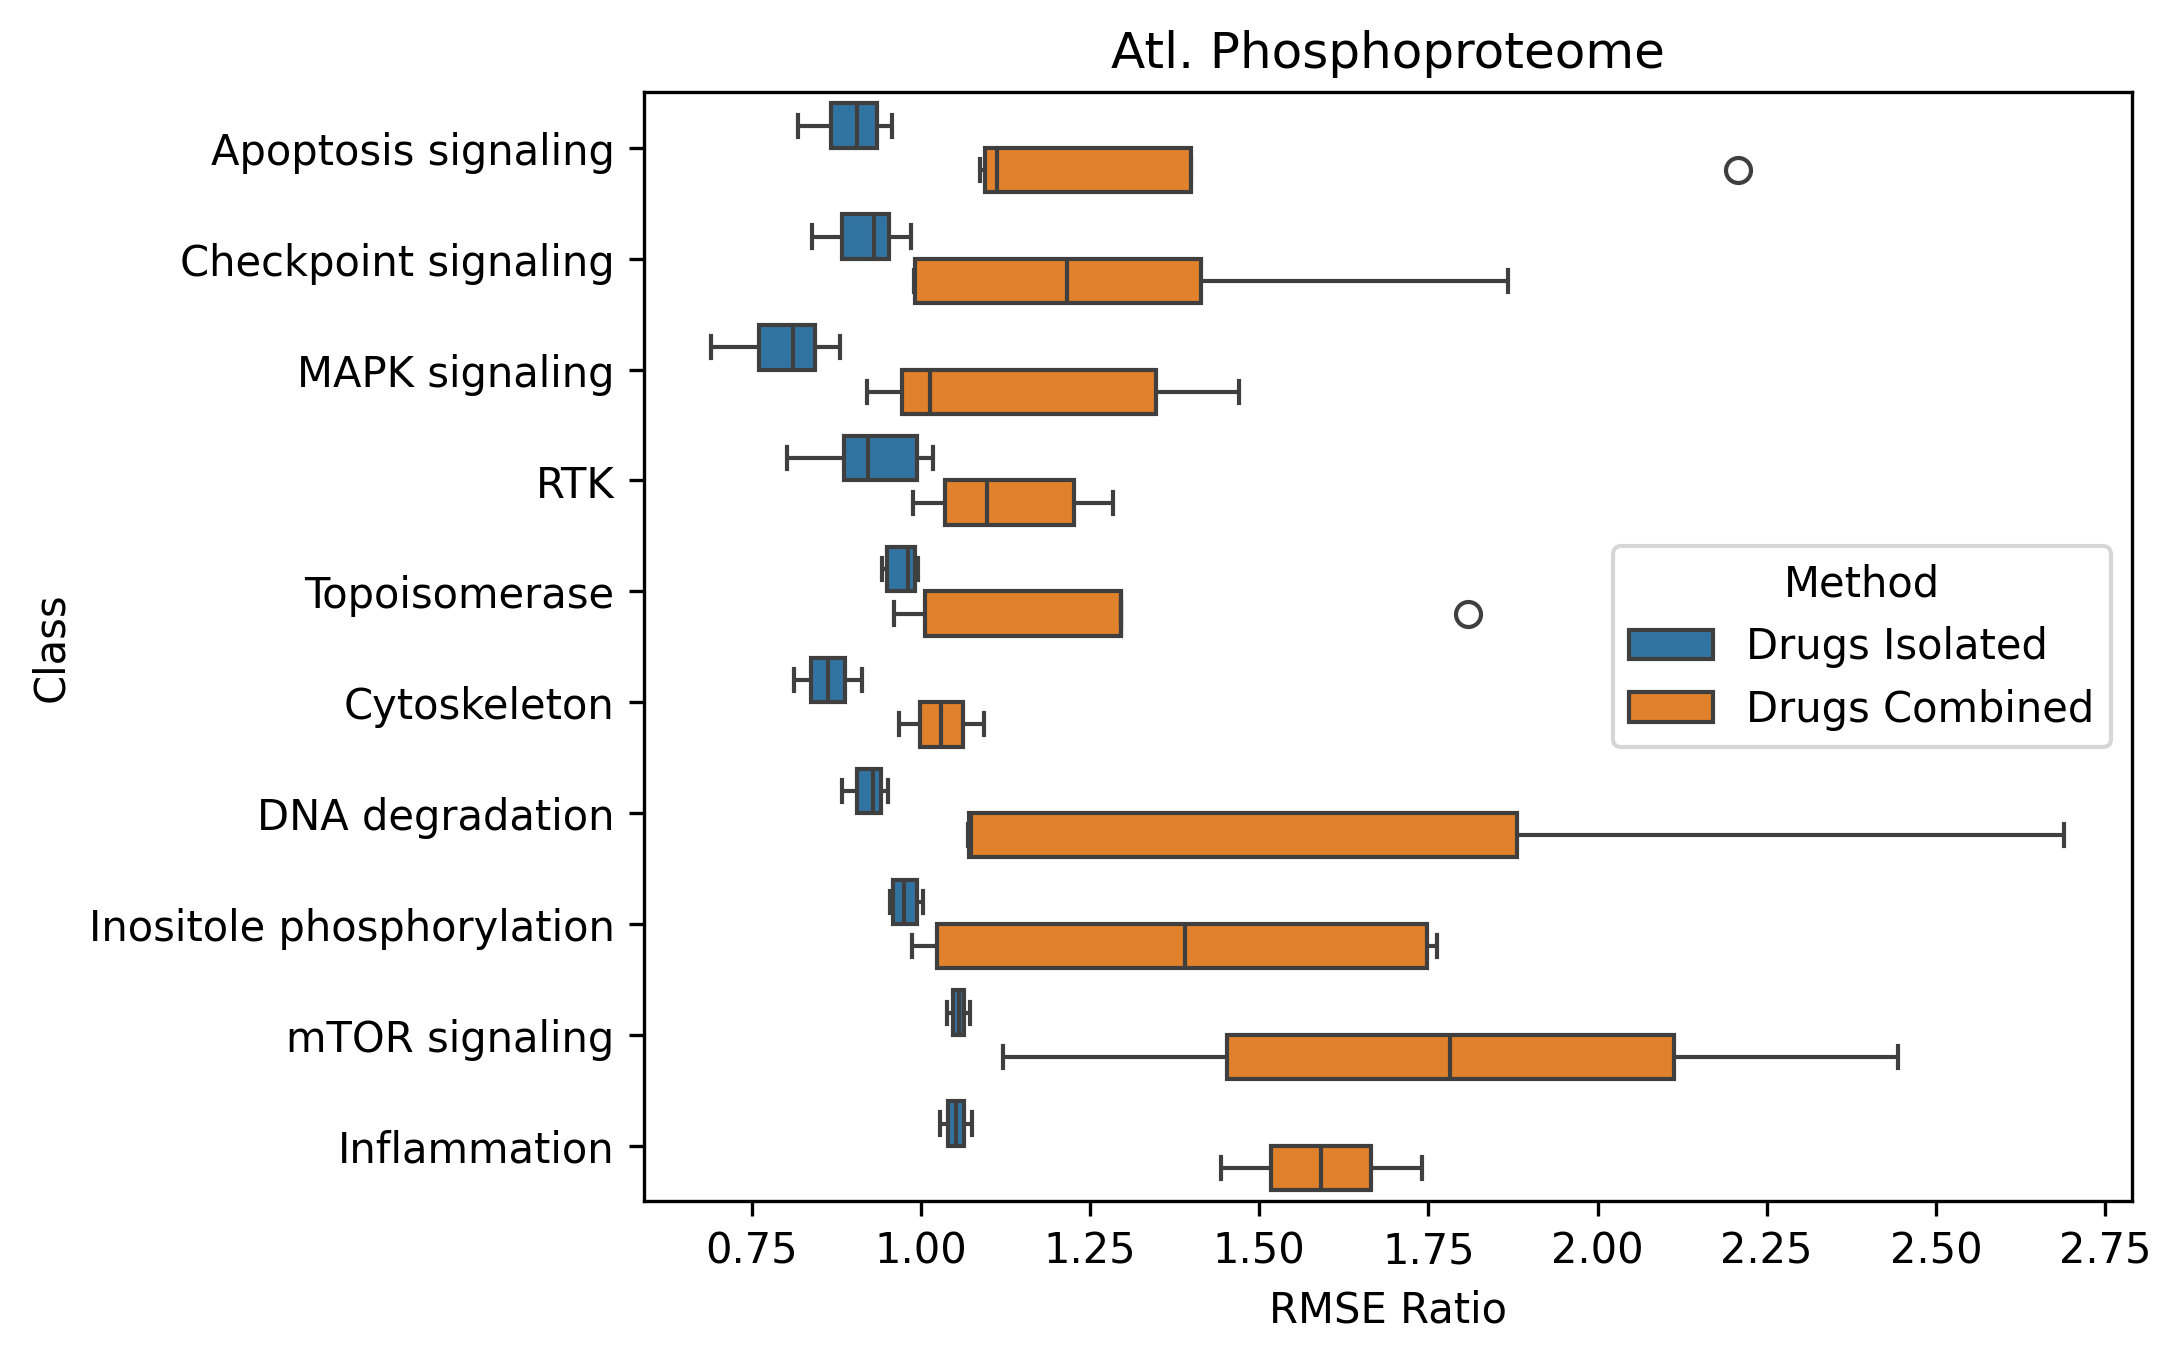

Gygi-CCLE


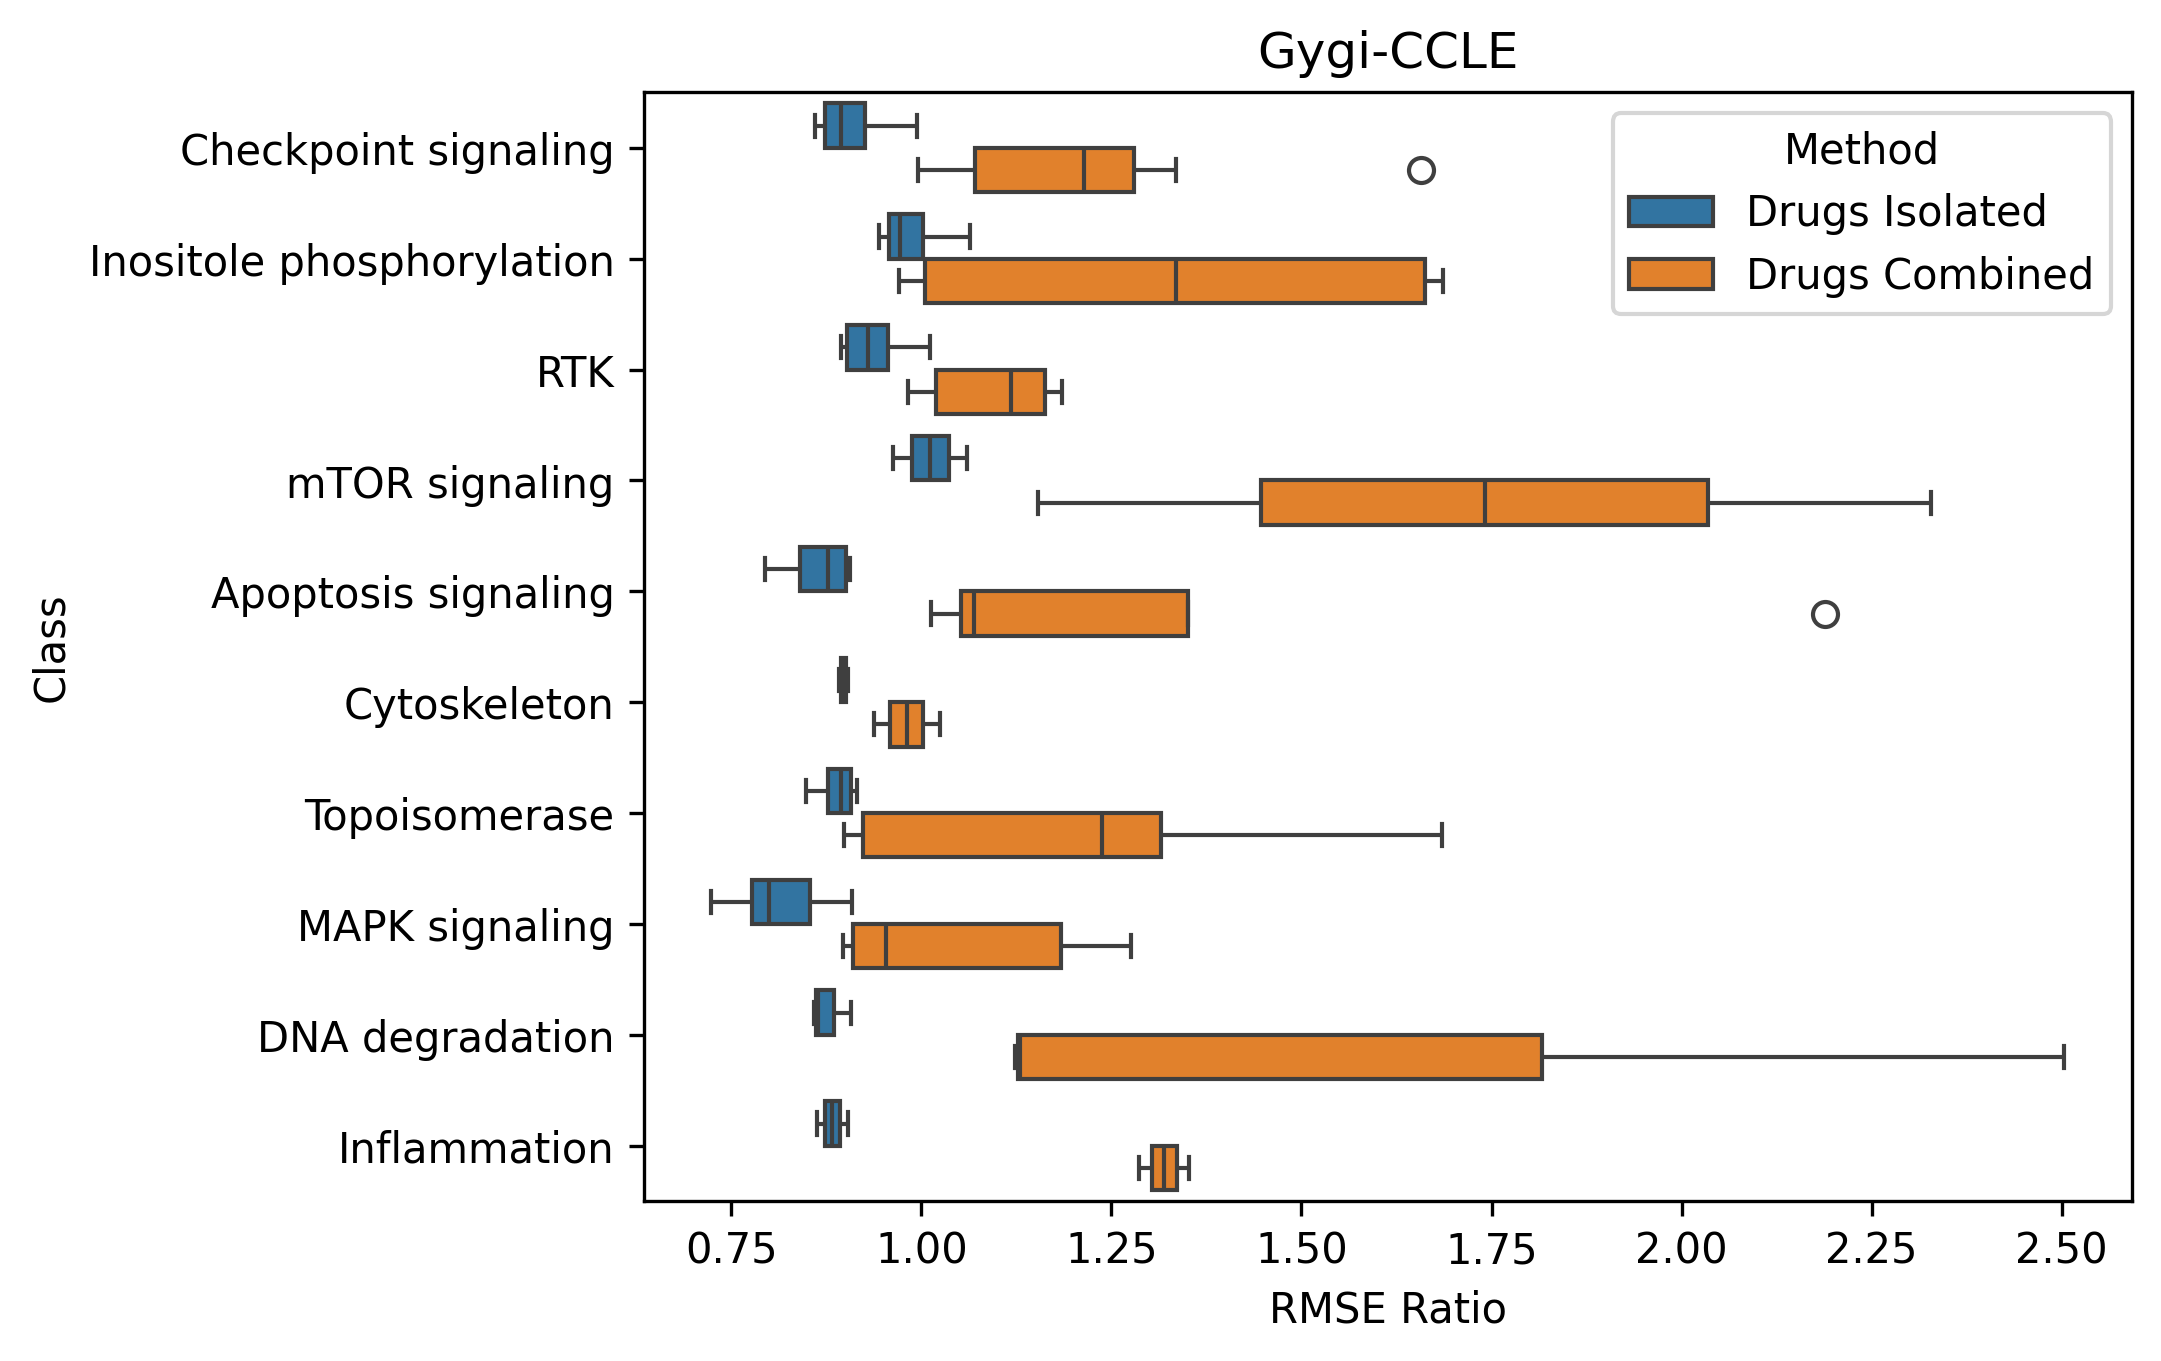

Tissue of Origin


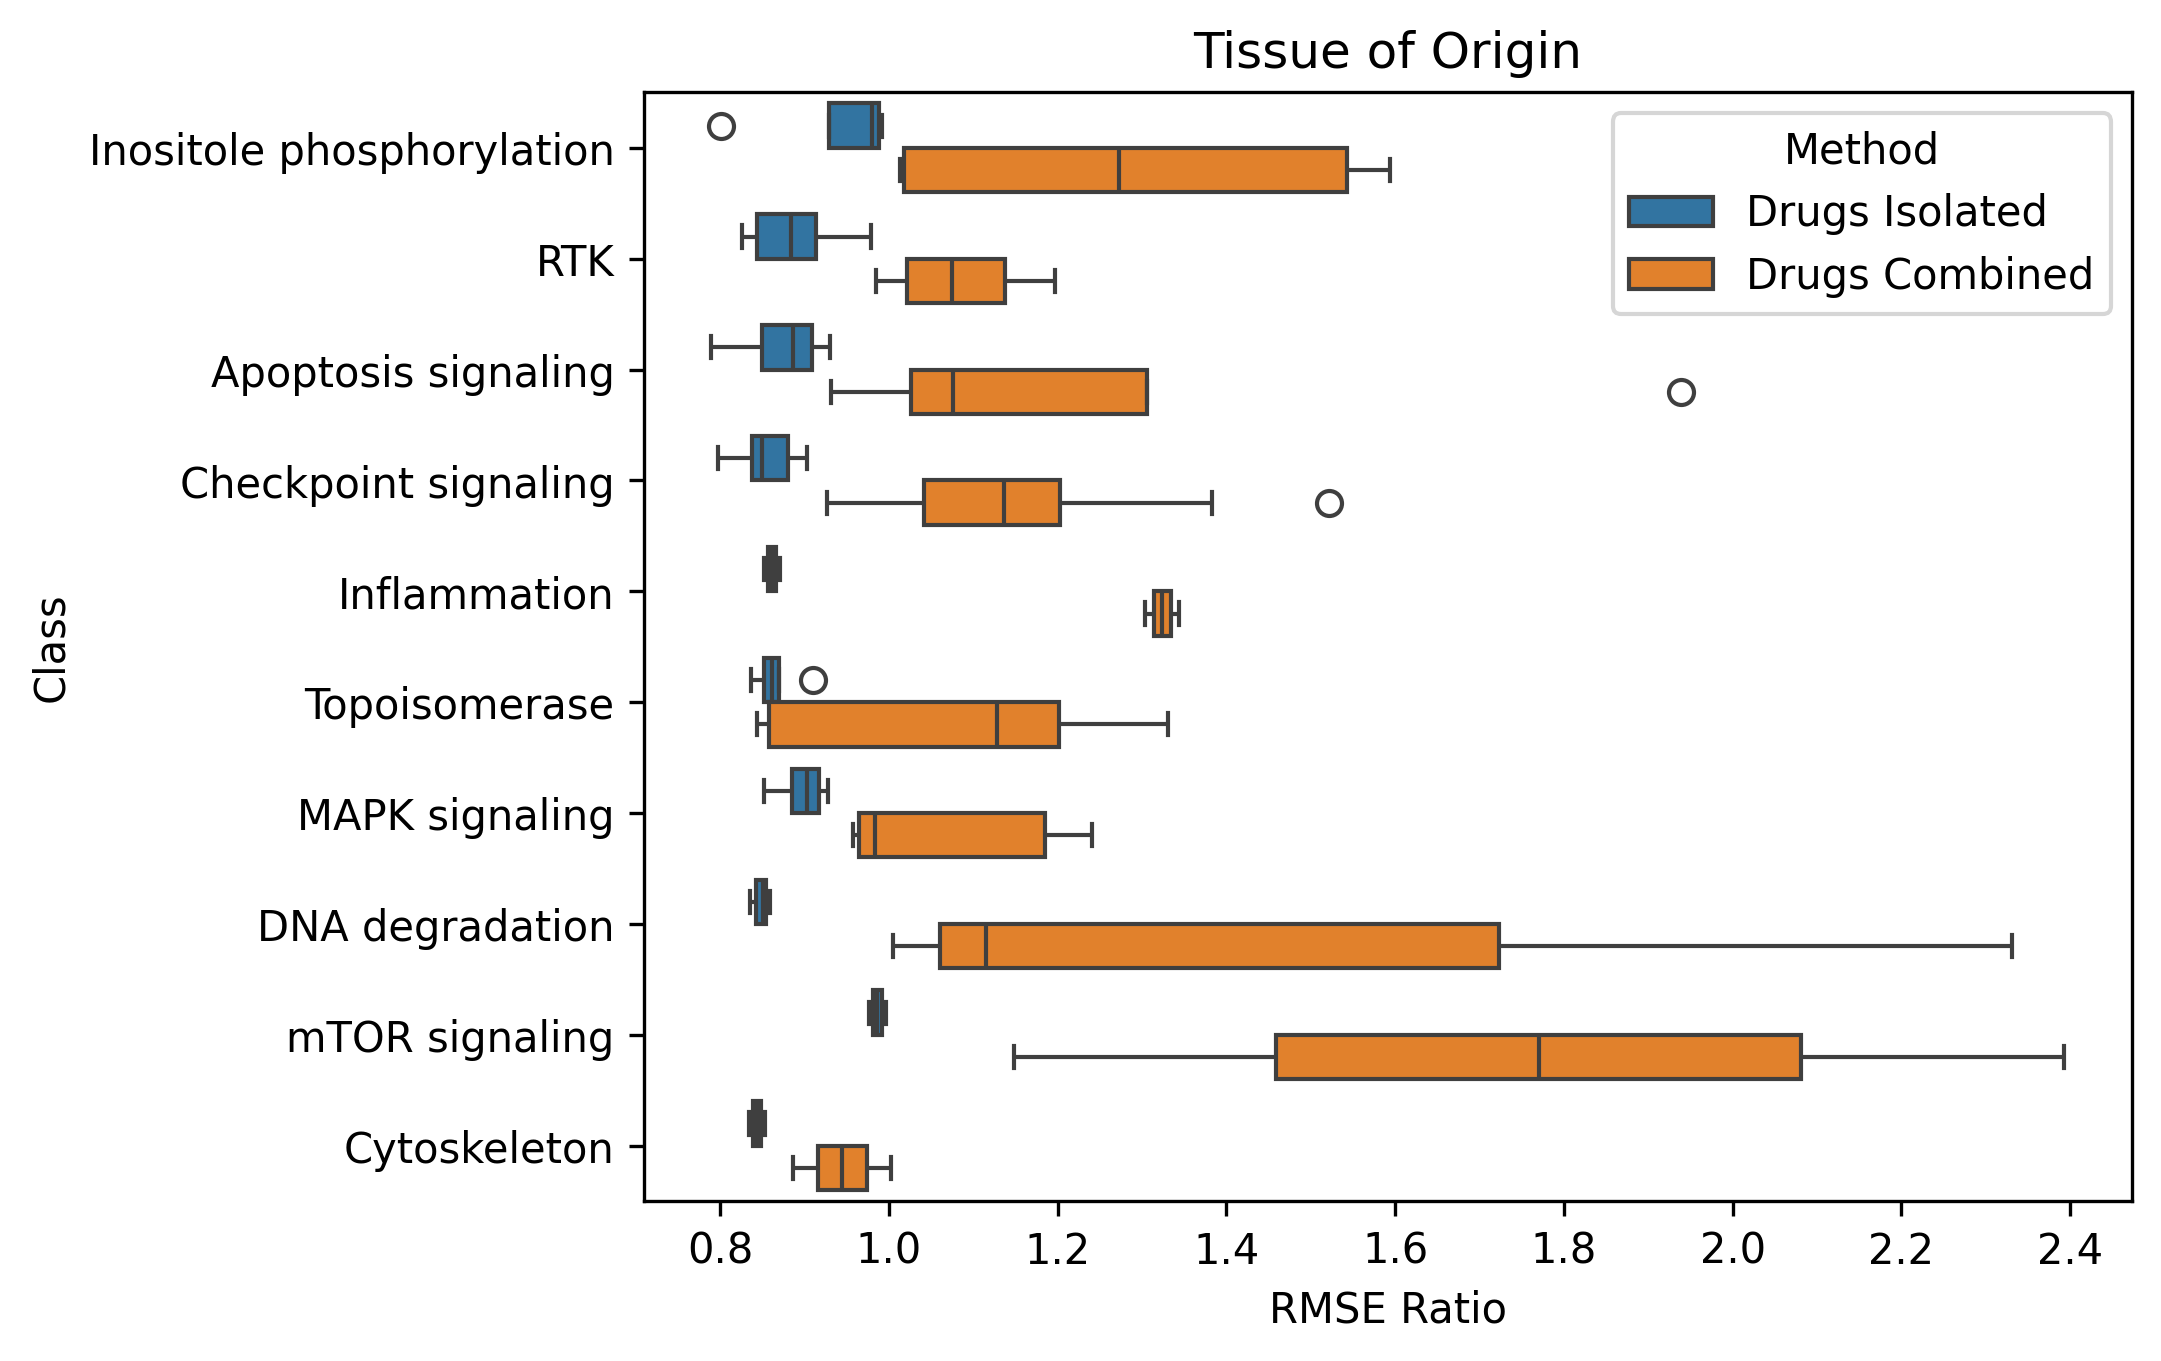

Transcriptomics


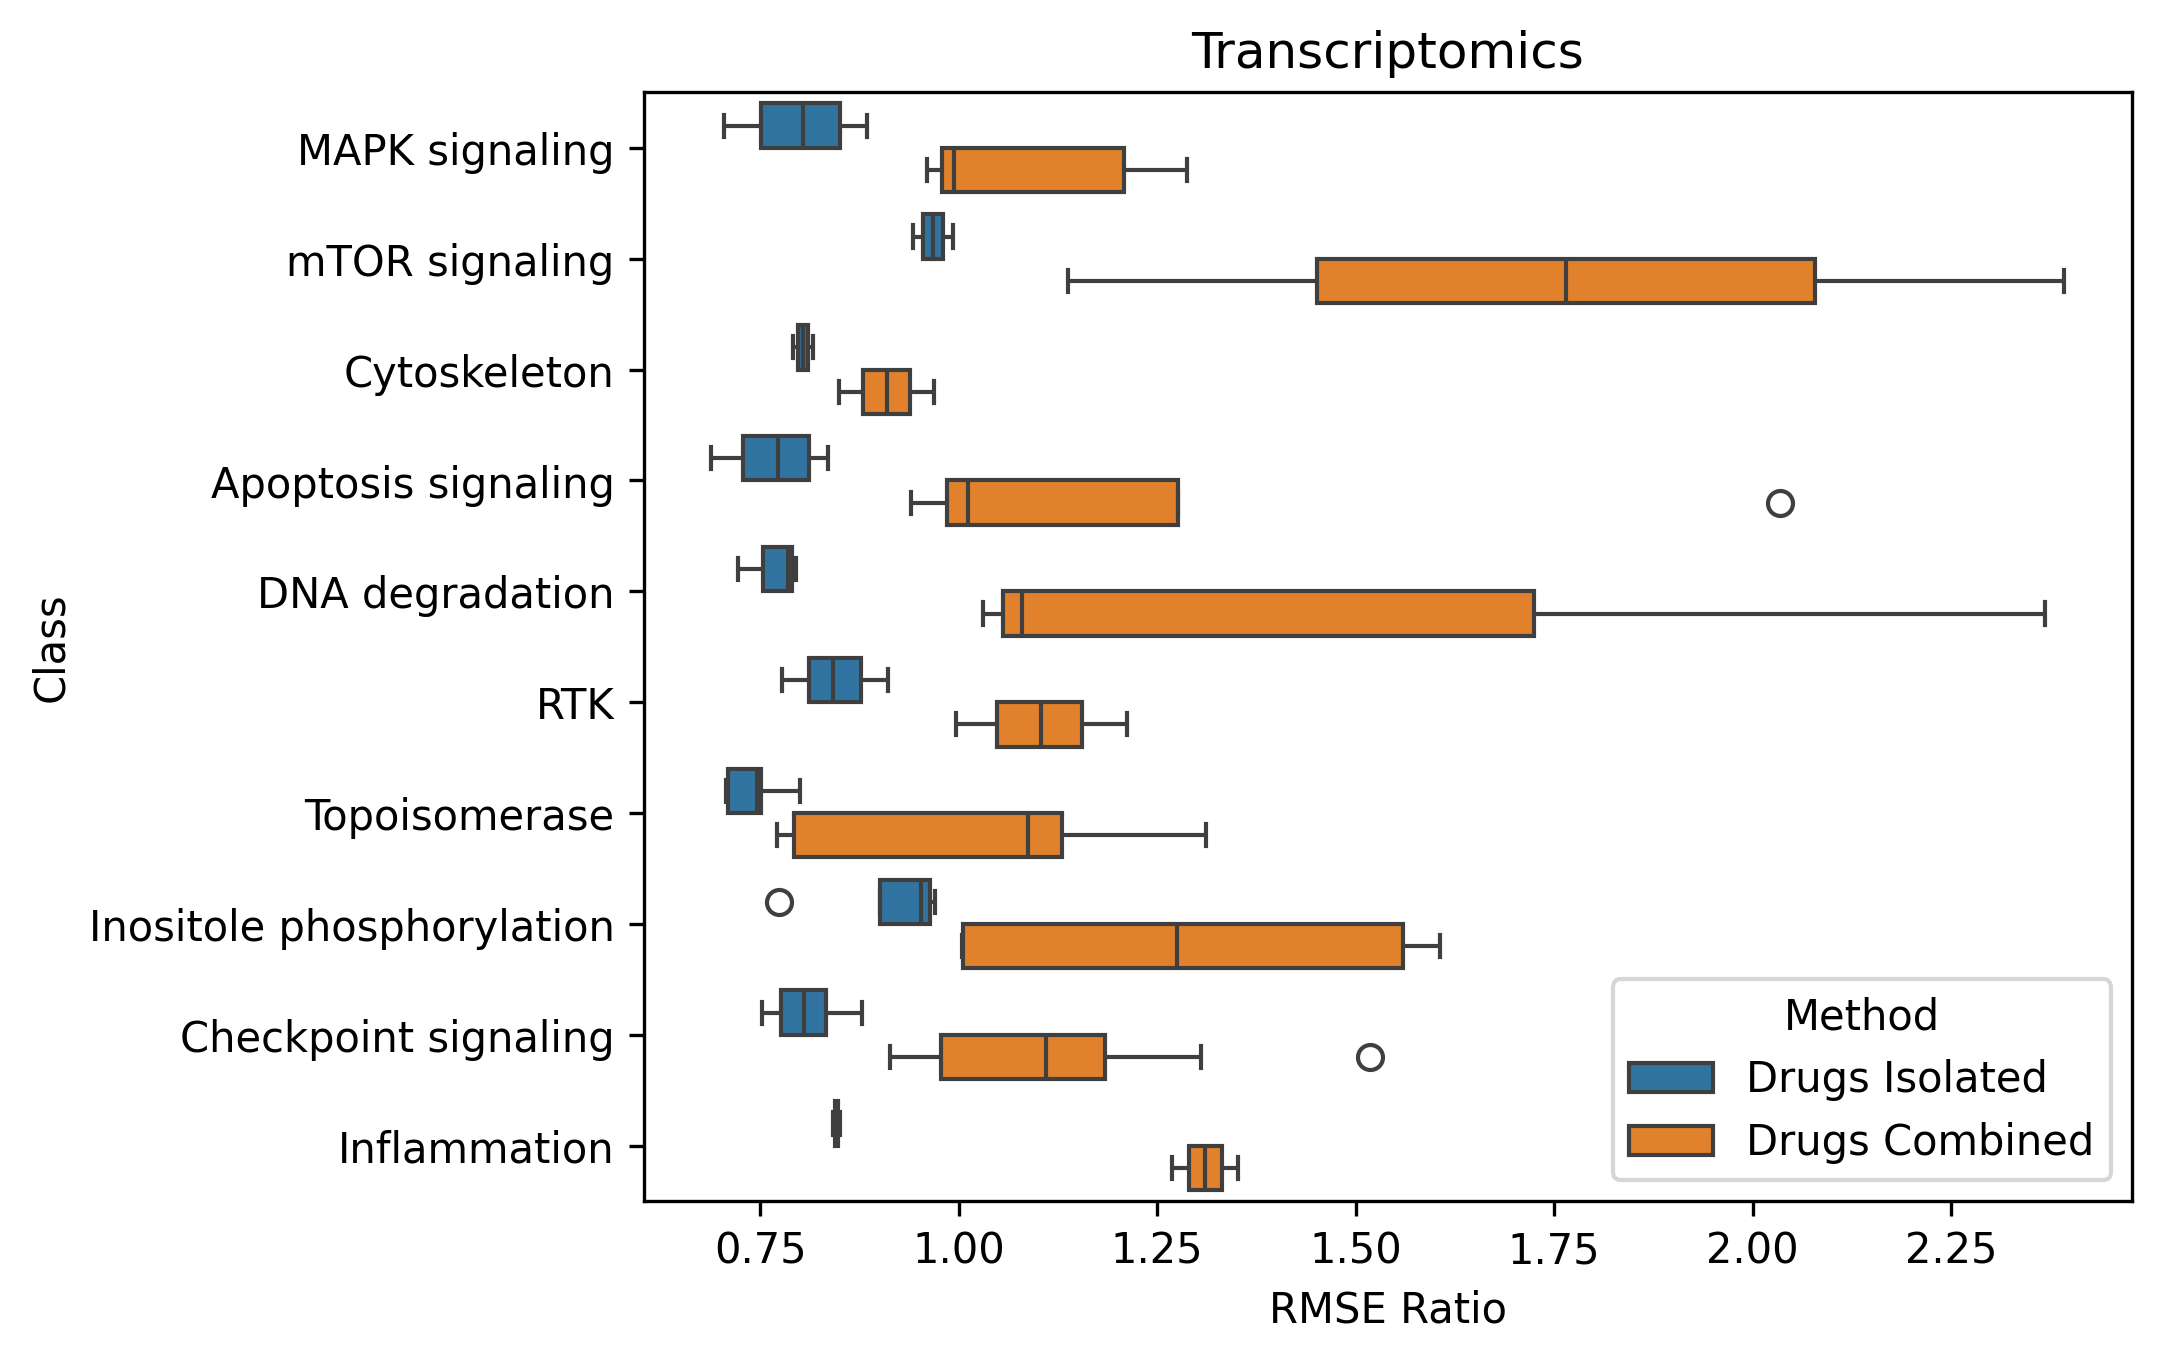

In [166]:
for dataset in datasets:
    print(dataset)
    Dfcs = Dfc[Dfc['dataset']==dataset].copy()
    vc = Dfcs['Class'].value_counts()
    Dfcss = Dfcs[Dfcs['Class'].isin(vc[vc>2].index)].copy()
    Dfcss['Class'] = list(Dfcss['Class'])
    sns.boxplot(data=Dfcss, x='RMSE_ratio', y='Class', hue='Method')
    plt.title(dataset)
    plt.xlabel('RMSE Ratio')
    plt.pause(0.01)